# 1 Load the function which is used to create df_paper and df_relationship

## 1.1 Import libraries

In [1]:
#encoding:utf-8
import pandas as pd 
from pandas import Series, DataFrame
import MySQLdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

## 1.2 Define some functions used to get some dataframes from mysql 

In [2]:
def get_paper(conn):
	sql_paper = "SELECT paper_id, paper_title, paper_publicationYear, paper_nbCitation, paper_label, venue_venue_id FROM paper"
	df_paper = pd.read_sql(sql_paper, conn)
	return df_paper

def get_a2p(conn):
	sql_a2p = "SELECT * FROM a2p"
	df_a2p = pd.read_sql(sql_a2p, conn)
	return df_a2p

def get_author(conn):
	sql_author = "SELECT * FROM author"
	df_author = pd.read_sql(sql_author, conn)
	return df_author

def get_relationship(conn):
	sql_relationship = "SELECT relationship_src, relationship_dst FROM relationship"
	df_relationship = pd.read_sql(sql_relationship, conn)
	return df_relationship

def get_venue(conn):
	sql_venue = "SELECT * FROM venue"
	df_venue = pd.read_sql(sql_venue, conn)
	return df_venue

def get_dblp2ccf(conn):
	sql_dblp2ccf = "SELECT * FROM dblp2ccf"
	df_dblp2ccf = pd.read_sql(sql_dblp2ccf, conn)
	return df_dblp2ccf

def get_ccf(conn):
	sql_ccf = "SELECT * FROM ccf"
	df_ccf = pd.read_sql(sql_ccf, conn)
	return df_ccf

def get_dblp2core(conn):
	sql_dblp2core = "SELECT * FROM dblp2core"
	df_dblp2core = pd.read_sql(sql_dblp2core, conn)
	return df_dblp2core

def get_core(conn):
	sql_core = "SELECT * FROM core"
	df_core = pd.read_sql(sql_core, conn)
	return df_core

## 1.3 Define function to get df_author, df_paper and df_relationship

In [3]:
def filter_author(sql_ip, port, user, passwd, db):
	conn = MySQLdb.connect(host=sql_ip, user=user, port=port, passwd=passwd, db=db, charset='utf8')
	df_a2p = get_a2p(conn)
	df_author = get_author(conn)
	df_tmp = pd.merge(df_author, df_a2p.drop_duplicates(['author_author_id']), left_on = 'author_id', right_on = 'author_author_id')
	df_tmp2 = df_tmp[['author_id', 'author_name', 'author_H_Index', 'author_tag', 'author_affiliation_name']]

	df_sub_China = df_tmp2[df_tmp2['author_affiliation_name'].str.contains('China')].copy()
	df_sub_Australia = df_tmp2[df_tmp2['author_affiliation_name'].str.contains('Australia')].copy()

	df_sub_China['country'] = 'China'
	df_sub_Australia['country'] = 'Australia'
	df_country = pd.concat([df_sub_China, df_sub_Australia])
	df_country = df_country.drop_duplicates(['author_id']) #去除2446篇第一作者来自两个国家的情况，这里将澳大利亚的情况去掉
	df_tmp3 = pd.merge(df_tmp2, df_country, how = 'outer')
	return df_tmp3

In [201]:
def generate_relationship(sql_ip, port, user, passwd, db):
    #根据数据库信息， 返回df_relationship，其中包含源和目的的发表年份、标签、最大H因子、第一作者所属国家

    conn = MySQLdb.connect(host=sql_ip, user=user, port=port, passwd=passwd, db=db, charset='utf8')

    df_paper = get_paper(conn)
    df_a2p = get_a2p(conn)
    df_author = get_author(conn)
    df_relationship = get_relationship(conn)
    df_venue = get_venue(conn)
    df_dblp2ccf = get_dblp2ccf(conn)
    df_ccf = get_ccf(conn)

    df_dblp2core = get_dblp2core(conn)
    df_core = get_core(conn)

    #*********************************************此部分得到论文的最大H因子********************************************************
    #合并, 内连接为了得到每个论文作者的最大H因子
    df = pd.merge(df_paper, pd.merge(df_author, df_a2p, left_on='author_id', right_on='author_author_id'), left_on='paper_id', right_on='paper_paper_id')

    #查看df的列名
    #df.columns

    #按paper_id分组
    group_paper = df.groupby(df['paper_id'])
    #得到paper的最大H因子
    res_Hindex = group_paper.author_H_Index.max()
    #计数，得到最大H因子的个数
    #res = res_Hindex.value_counts()

    #找到作者最大H因子，写到df_paper中
    df_Hindex = DataFrame(res_Hindex)
    df_Hindex['paper_id'] = df_Hindex.index

    #*************************************此部分得到论文的J/C、computercategory***************************************************
    df2_part1 = pd.merge(df_paper, df_venue, left_on='venue_venue_id', right_on='venue_id')
    df2_part2 = pd.merge(df_ccf, df_dblp2ccf, left_on='CCF_id', right_on='ccf_CCF_id')
    df2_part2 = df2_part2[df2_part2['dblp_dblp_id']<999999999]
    df2 = pd.merge(df2_part1, df2_part2, left_on='dblp_dblp_id', right_on='dblp_dblp_id')
    df2 = df2[['paper_id', 'CCF_type', 'computercategory_computerCategory_id', 'CCF_id']] #加上论文的CCF_id
    df2 = df2.drop_duplicates(['paper_id']) #去掉重复的paper_id数据

    df2_part3 = pd.merge(df_core, df_dblp2core, left_on='CORE_id', right_on='core_CORE_id')
    df2_part3 = df2_part3[df2_part3['dblp_dblp_id']<999999999]
    df3 = pd.merge(df2_part1, df2_part3, left_on='dblp_dblp_id', right_on='dblp_dblp_id')
    df3 = df3[['paper_id', 'CORE_id']]
    df3 = df3.drop_duplicates(['paper_id'])
    
    df2 = pd.merge(df2, df3, left_on='paper_id', right_on='paper_id', how='outer')

    df_paper = pd.merge(df_paper, df_Hindex, left_on='paper_id', right_on='paper_id', how='outer') #在paper表上加上Max H因子
    df_paper = pd.merge(df_paper, df2, left_on='paper_id', right_on='paper_id', how='outer') #在paper表上加上J/C, computer类别

    #找到每篇论文第一作者的国籍，写入df_paper中
    df_sub = df[df['a2p_order']==1]
    df_sub2 = df_sub[['paper_id', 'author_affiliation_name']]
    df_sub_China = df_sub2[df_sub2['author_affiliation_name'].str.contains('China')].copy()
    df_sub_Australia = df_sub2[df_sub2['author_affiliation_name'].str.contains('Australia')].copy()

    df_sub_China['country'] = 'China'
    df_sub_Australia['country'] = 'Australia'
    df_country = pd.concat([df_sub_China, df_sub_Australia])
    df_country = df_country.drop_duplicates(['paper_id']) #去除2446篇第一作者来自两个国家的情况，这里将澳大利亚的情况去掉

    #df_paper_inter = pd.merge(df_paper, df_country) #只包括中国和澳大利亚作者
    df_paper_outer = pd.merge(df_paper, df_country, how = 'outer')#包括所有国家作者，但是大部分国籍为NAN(除中澳外的其他国家)

    df_relationship = pd.merge(df_relationship, df_paper_outer[['paper_id','paper_publicationYear','paper_label','author_H_Index', 'CCF_type', 'computercategory_computerCategory_id', 'country', 'CCF_id']], left_on='relationship_src', right_on='paper_id')
    del df_relationship['paper_id']
    #换列名
    df_relationship.columns = ['relationship_src', 'relationship_dst', 'relationship_src_publicationYear', 'relationship_src_label', 'relationship_src_maxHindex', 'relationship_src_type', 'relationship_src_computerCategory', 'relationship_src_country', 'relationship_src_ccfid']

    df_relationship = pd.merge(df_relationship, df_paper_outer[['paper_id','paper_publicationYear','paper_label','author_H_Index', 'CCF_type', 'computercategory_computerCategory_id', 'country', 'CCF_id']], left_on='relationship_dst', right_on='paper_id')
    del df_relationship['paper_id']
    df_relationship.columns = ['relationship_src', 'relationship_dst', 'relationship_src_publicationYear', 'relationship_src_label', 'relationship_src_maxHindex', 'relationship_src_type', 'relationship_src_computerCategory', 'relationship_src_country', 'relationship_src_ccfid', 'relationship_dst_publicationYear', 'relationship_dst_label', 'relationship_dst_maxHindex', 'relationship_dst_type', 'relationship_dst_computerCategory', 'relationship_dst_country', 'relationship_dst_ccfid']
    #此时的df_relationship包含源和目的的发表年份、标签、最大H因子、type、 CCF类别、第一作者所属国家

    return df_paper_outer, df_relationship

## 1.4 Load mysql parameters

In [5]:
#sql_ip = "shhr.online" #数据库地址
#port = 33755 #数据库端口号
sql_ip = "192.168.1.198"
#sql_ip = "127.0.0.1"
port = 3306
user = "jingfei" #用户名
#user = "root"
passwd = "hanjingfei007"
db = "aminer_gai"

## 1.5 Create DataFrames 

In [202]:
df_paper, df_relationship = generate_relationship(sql_ip, port, user, passwd, db)
df_author = filter_author(sql_ip, port, user, passwd, db)

df_author's parameters include **author_id, author_name, author_H_Index, author_tag, author_affiliation_name, country**

In [7]:
df_author.head()

,author_id,author_name,author_H_Index,author_tag,author_affiliation_name,country
0,1,O. Willum,0,new product;product group;active product;long ...,"Res. Center for Microperipherik, Technische Un...",NaN
1,2,D. Wei,0,lowpass filter;multidimensional product filter...,"Dept. of Electr. & Comput. Eng., Drexel Univ.,...",NaN
2,3,Wenhu Wu,0,MAP adaptation;adaptation data;adaptation utte...,,NaN
3,4,Zhiyuan Zeng,0,normalized difference vegetation index;ratio v...,"College of Geography Science, Nanjing Normal U...",China
4,5,Erzen Hyko,0,information content;Spatio-Temporal Informatio...,"Department of Computer Science, University of ...",NaN


df_paper's parameters include **paper_id, paper_title, paper_publicationYear, paper_nbCitation, paper_label, venue_venue_id, author_H_index, CCF_type, computercategory_computerCategory_id, CCF_id, author_affiliation_name, country**

In [8]:
df_paper.head() #原始的paper信息加上最大作者H因子、J/C、计算机类别、CCF id、作者名、第一作者国家

,paper_id,paper_title,paper_publicationYear,paper_nbCitation,paper_label,venue_venue_id,author_H_Index,CCF_type,computercategory_computerCategory_id,CCF_id,author_affiliation_name,country
0,1276,Computer algebra applications,2000,0,None,8292,6.0,NaN,NaN,NaN,NaN,NaN
1,2484,The development of computer science,2000,4,None,8293,3.0,NaN,NaN,NaN,NaN,NaN
2,3019,A query interface for IMAGE databases based on...,2000,0,None,8294,11.0,NaN,NaN,NaN,"Royal Melbourne Institute of Technology, Melbo...",Australia
3,3020,Quokka: a translator generator using denotatio...,2000,0,None,8294,2.0,NaN,NaN,NaN,"Univ. of New South Wales, Kensington, NSW, Aus...",Australia
4,3021,A clause indexing system for PROLOG based on s...,2000,0,None,8294,6.0,NaN,NaN,NaN,"Univ. of New South Wales, Sydney, Australia;Un...",Australia


df_relationship is used to show citation relationship. Its parameters include 

**relationship_src, relationship_dst**

**relationship_src_publicationYear, relationship_src_label, relationship_src_maxHindex, relationship_src_type, 
relationship_src_computerCategory, relationship_src_country, relationship_src_ccfid**

**relationship_dst_publicationYear, relationship_dst_label, relationship_dst_maxHindex, relationship_dst_type, 
relationship_dst_computerCategory, relationship_dst_country, relationship_dst_ccfid**

In [9]:
df_relationship.head()

,relationship_src,relationship_dst,relationship_src_publicationYear,relationship_src_label,relationship_src_maxHindex,relationship_src_type,relationship_src_computerCategory,relationship_src_country,relationship_src_ccfid,relationship_dst_publicationYear,relationship_dst_label,relationship_dst_maxHindex,relationship_dst_type,relationship_dst_computerCategory,relationship_dst_country,relationship_dst_ccfid
0,54484,54476,2000,None,3.0,NaN,NaN,NaN,NaN,2000,None,1.0,NaN,NaN,NaN,NaN
1,54476,54484,2000,None,1.0,NaN,NaN,NaN,NaN,2000,None,3.0,NaN,NaN,NaN,NaN
2,54573,54572,2000,None,20.0,NaN,NaN,NaN,NaN,2000,None,9.0,NaN,NaN,NaN,NaN
3,333245,179374,2001,None,28.0,NaN,NaN,NaN,NaN,2011,None,2.0,NaN,NaN,NaN,NaN
4,333964,179374,2001,None,49.0,NaN,NaN,NaN,NaN,2011,None,2.0,NaN,NaN,NaN,NaN


## 1.6 Preprocess

### 1.6.1 Drop the relationship bug

There are some bugs in our dataset. In there, we try to delete 32,151 items in table relationship whose destination publication year is smaller than its source publication year.

In [10]:
#df_relationship[df_relationship['relationship_src_publicationYear'] > df_relationship['relationship_dst_publicationYear']]
df_relationship = df_relationship[df_relationship['relationship_src_publicationYear'] <= df_relationship['relationship_dst_publicationYear']]

# 2 Data analysis for df_paper, df_author

## 2.1 Data basic characteristic

### 2.1.1 The number of papers from China and Australia

country
Australia     29649
China        110378
dtype: int64


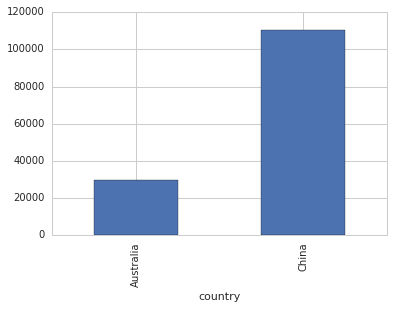

In [11]:
grouped = df_paper.groupby(['country'])['paper_id'].size()
print grouped
grouped.plot(kind='bar')

### 2.1.2 The number of authors from China and Australia

country
Australia     15243
China        105464
dtype: int64


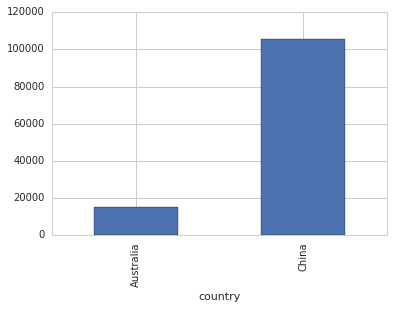

In [12]:
grouped = df_author.groupby(['country'])['author_id'].size()
print grouped
grouped.plot(kind='bar')

### 2.1.3 Show the yearly number of publicationsfrom 2000 to 2014.

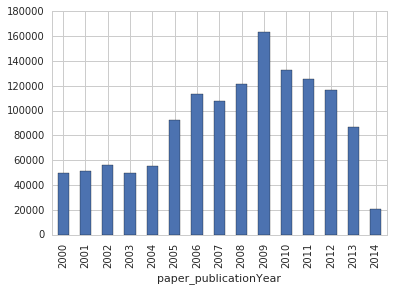

In [13]:
df_paper.groupby(['paper_publicationYear'])['paper_id'].size().plot(kind='bar')

We can find that the number of publications grew at an exponential rate from 2000 to 2009. But decreased since 2010. This is different from other papers and intuition.

I think it's because our dataset is **incomplete**. So I think we can only use this dataset to reasearch the difference betweenCCF and CORE.

If we want to predict citation, we need to use the complete [Academic Social Networks](https://aminer.org/aminernetwork).

But I think we need to consider the latest citation data in AMiner -- [citation](https://aminer.org/citation). The data is only for citation research.

In the citation dataset, no author informations are considered. So I think we can use the data from 2000 to 2009.

## 2.2 Test if multiple authors receive more citations than solo-authored ones. [BY Wuchty](http://www.kellogg.northwestern.edu/faculty/uzzi/ftp/teams.printversion.pdf)

In [14]:
conn = MySQLdb.connect(host=sql_ip, user=user, port=port, passwd=passwd, db=db, charset='utf8')
df_a2p = get_a2p(conn)

In [15]:
df_a2p.head()

,a2p_id,a2p_order,author_author_id,paper_paper_id
0,2141,1,565329,1276
1,2142,2,518281,1276
2,4172,1,1708068,2484
3,5035,1,232108,3019
4,5036,2,39675,3019


In [16]:
grouped_paper = df_a2p.groupby('paper_paper_id')['author_author_id'].size()

In [17]:
grouped_paper.index

Int64Index([   1276,    2484,    3019,    3020,    3021,    3022,    3053,
               3054,    3055,    3056,
            ...
            2091249, 2091250, 2091251, 2092350, 2092351, 2092352, 2092353,
            2092354, 2092355, 2092356],
           dtype='int64', name=u'paper_paper_id', length=1305906)

In [18]:
df_cntAuthor = DataFrame(grouped_paper, columns=['cntAuthor'])

In [19]:
df_tmp = pd.merge(df_paper, df_cntAuthor, left_on='paper_id', right_index=True, how='left')

In [20]:
df_tmp.head()

,paper_id,paper_title,paper_publicationYear,paper_nbCitation,paper_label,venue_venue_id,author_H_Index,CCF_type,computercategory_computerCategory_id,CCF_id,author_affiliation_name,country,cntAuthor
0,1276,Computer algebra applications,2000,0,None,8292,6.0,NaN,NaN,NaN,NaN,NaN,2.0
1,2484,The development of computer science,2000,4,None,8293,3.0,NaN,NaN,NaN,NaN,NaN,1.0
2,3019,A query interface for IMAGE databases based on...,2000,0,None,8294,11.0,NaN,NaN,NaN,"Royal Melbourne Institute of Technology, Melbo...",Australia,2.0
3,3020,Quokka: a translator generator using denotatio...,2000,0,None,8294,2.0,NaN,NaN,NaN,"Univ. of New South Wales, Kensington, NSW, Aus...",Australia,1.0
4,3021,A clause indexing system for PROLOG based on s...,2000,0,None,8294,6.0,NaN,NaN,NaN,"Univ. of New South Wales, Sydney, Australia;Un...",Australia,2.0


In [21]:
li = range(10)
li.extend([200])
cut = pd.cut(df_tmp.cntAuthor, li)

In [22]:
cut.value_counts()

(1, 2]      387928
(2, 3]      347888
(0, 1]      207720
(3, 4]      203225
(4, 5]       88794
(5, 6]       37380
(6, 7]       15405
(7, 8]        7544
(9, 200]      6181
(8, 9]        3841
Name: cntAuthor, dtype: int64

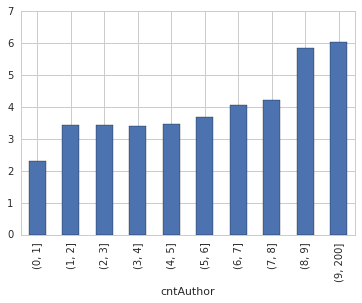

In [23]:
df_tmp.groupby(cut)['paper_nbCitation'].mean().plot(kind='bar')

We can find this phenomenon: the average citation number from papers which is finished by only one people is less than finished by more people.

## 2.3 Power-law distribution

### 2.3.1 Distribution of the number of all citations of papers.

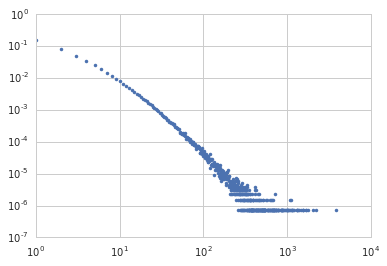

In [24]:
grouped = df_paper.groupby('paper_nbCitation')['paper_id'].size()
fre = grouped * 1.0/ grouped.sum()
plt.loglog(fre.index, fre.values, '.')

### 2.3.2 Distribution of the number of citations of papers received within 5 years after publication.

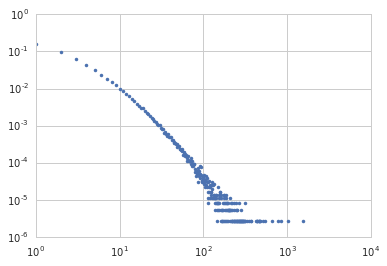

In [25]:
df_tmp = df_relationship[df_relationship['relationship_dst_publicationYear'] - df_relationship['relationship_src_publicationYear'] <= 5]

df_tmp = df_tmp[df_tmp['relationship_src_publicationYear'] <= 2005]

grouped = df_tmp.groupby('relationship_src')['relationship_dst'].size()

grouped = DataFrame(grouped, columns=['cnt_5years'])

df_paper_tmp = df_paper[df_paper['paper_publicationYear'] <= 2005]
df_merge = pd.merge(df_paper_tmp, grouped, left_on='paper_id', right_index=True, how='left')
df_merge['cnt_5years'] = df_merge['cnt_5years'].fillna(0)
grouped2 = df_merge.groupby('cnt_5years')['paper_id'].size()
fre = grouped2 * 1.0/ grouped2.sum()
plt.loglog(fre.index, fre.values, '.')

# 3 Data analysis for df_relationship

## 3.1 Data basic characteristic

### 3.1.1 Divide authors according to H index

First, we can observe the statistic feauther about author H index.

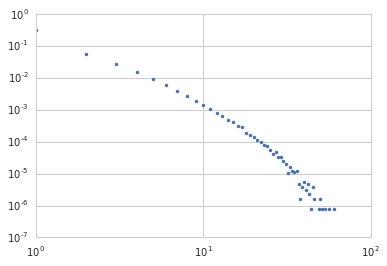

In [26]:
grouped = df_author.groupby('author_H_Index')['author_id'].size()
fre = grouped * 1.0/ grouped.sum()
plt.loglog(fre.index, fre.values, '.')
#grouped.plot(kind='bar')

In [27]:
df_author[df_author['author_H_Index']>0]['author_H_Index'].quantile([1, 0.99, 0.9, 0.75, 0.5, 0.25, 0])
#In there, we compute quantile except H-index is equal to 0 because most of them are students and only published one paper.

1.00    60.0
0.99    11.0
0.90     4.0
0.75     2.0
0.50     1.0
0.25     1.0
0.00     1.0
Name: author_H_Index, dtype: float64

We find that author's H index is subject to the power law distribution. Hence, we can divide authors into 5 parts, including:
+ **top H-index author （*top 1%:*  $H index \in [11, 60]$ ）**
+ **high H-index author （*top 10%:* $H index \in [4, 11)$）**
+ **higher H-index author （*top 25%:* $H index \in [2, 4)$）**
+ **lower H-index author （*H-index >= 1:* $H index \in [1, 2)$）**
+ **low H-index author （*H-index=0:* $H index \in [0, 1)$）**

Following is the number of publications of every author.

In [28]:
grouped = df_a2p.groupby(['author_author_id'])['a2p_id'].size()
grouped.describe()

count    1.277094e+06
mean     2.967273e+00
std      7.133561e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.730000e+02
dtype: float64

We can find more than half authors pulished only 1 paper. 

Now we can get the relationship between the number of pulication and author H-index.

In [29]:
df_tmp = DataFrame(grouped)
df_tmp.columns = ['cntPub']

df_tmp = pd.merge(df_tmp, df_author, left_index=True, right_on='author_id')

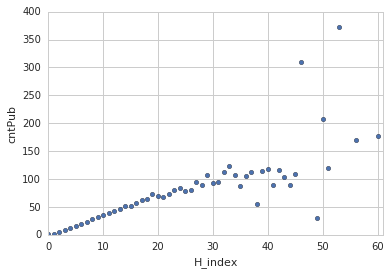

In [30]:
df_tmp2 = df_tmp.groupby(['author_H_Index'])['cntPub', 'author_id'].mean()
df_tmp2['H_index'] = df_tmp2.index
#df_tmp2
df_tmp2.plot(kind='scatter', x='H_index', y='cntPub', xlim=[0, 61], ylim=[0, 400])
#df_tmp2 = DataFrame(df_tmp2)

We can find there is a linear correlation between the two feaures expect H-index > 38, especially greater than 48. I think this phenomenon is because we have less top authors. For example, there are 40 authors which H-index is greater than 38 and 7 authors which H-index is greater than 48.

In [31]:
df_author[df_author['author_H_Index'] > 48]['author_id'].count()

7

## 3.2 Computer category's distribution of the overlap between CCF and CORE

In [32]:
df_ccf = get_ccf(conn)
df_dblp2ccf = get_dblp2ccf(conn)
df_core = get_core(conn)
df_dblp2core = get_dblp2core(conn)

df_dblp2ccf = df_dblp2ccf[df_dblp2ccf.dblp_dblp_id < 999999999]
df_dblp2core = df_dblp2core[df_dblp2core.dblp_dblp_id < 999999999]

df_ccf_tmp = pd.merge(df_ccf, df_dblp2ccf, left_on='CCF_id', right_on='ccf_CCF_id')
df_core_tmp = pd.merge(df_core, df_dblp2core, left_on='CORE_id', right_on='core_CORE_id')
df_merge = pd.merge(df_ccf_tmp, df_core_tmp)

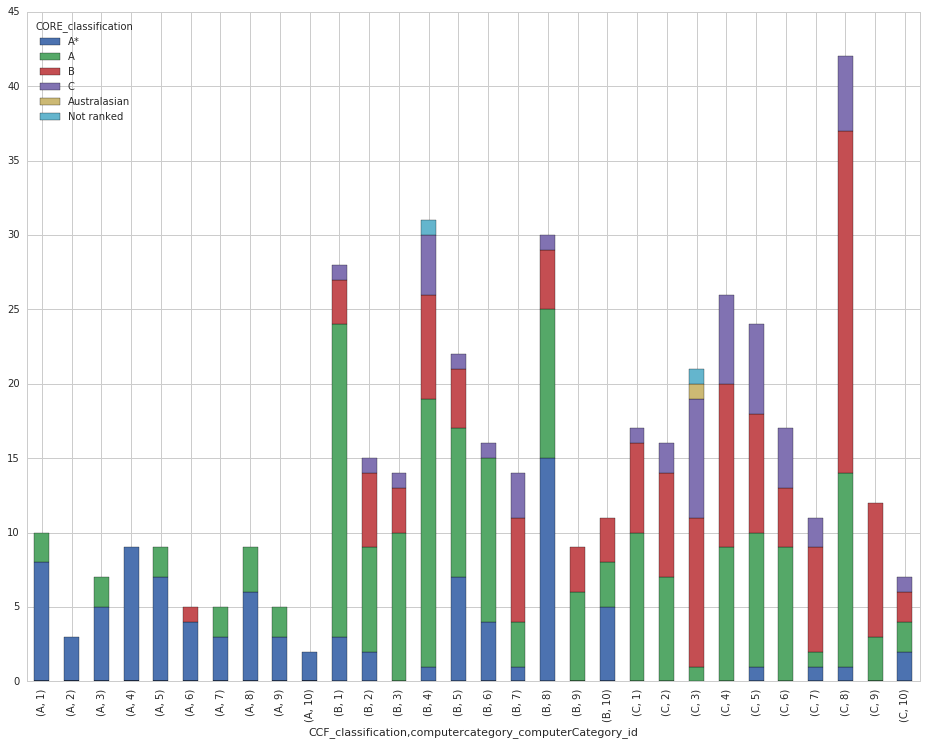

In [33]:
df_merge2 = df_merge[['CCF_id','CCF_classification', 'computercategory_computerCategory_id', 'CORE_classification']]
grouped = df_merge2.groupby(['CCF_classification', 'computercategory_computerCategory_id', 'CORE_classification'])['CCF_id'].size().unstack()

grouped2 = grouped[['A*', 'A', 'B', 'C', 'Australasian', 'Not ranked']]
grouped2.plot(kind='bar', stacked=True, figsize=(16, 12))

In [34]:
grouped2

CORE_classification                                        A*     A     B  \
CCF_classification computercategory_computerCategory_id                     
A                  1                                      8.0   2.0   NaN   
                   2                                      3.0   NaN   NaN   
                   3                                      5.0   2.0   NaN   
                   4                                      9.0   NaN   NaN   
                   5                                      7.0   2.0   NaN   
                   6                                      4.0   NaN   1.0   
                   7                                      3.0   2.0   NaN   
                   8                                      6.0   3.0   NaN   
                   9                                      3.0   2.0   NaN   
                   10                                     2.0   NaN   NaN   
B                  1                                      3.0  21.0   3.0   
                   2                                      2.0   7.0   5.0   
                   3                                      NaN  10.0   3.0   
                   4                                      1.0  18.0   7.0   
                   5                                      7.0  10.0   4.0   
                   6                                      4.0  11.0   NaN   
                   7                                      1.0   3.0   7.0   
                   8                                     15.0  10.0   4.0   
                   9                                      NaN   6.0   3.0   
                   10                                     5.0   3.0   3.0   
C                  1                                      NaN  10.0   6.0   
                   2                                      NaN   7.0   7.0   
                   3                                      NaN   1.0  10.0   
                   4                                      NaN   9.0  11.0   
                   5                                      1.0   9.0   8.0   
                   6                                      NaN   9.0   4.0   
                   7                                      1.0   1.0   7.0   
                   8                                      1.0  13.0  23.0   
                   9                                      NaN   3.0   9.0   
                   10                                     2.0   2.0   2.0   

CORE_classification                                        C  Australasian  \
CCF_classification computercategory_computerCategory_id                      
A                  1                                     NaN           NaN   
                   2                                     NaN           NaN   
                   3                                     NaN           NaN   
                   4                                     NaN           NaN   
                   5                                     NaN           NaN   
                   6                                     NaN           NaN   
                   7                                     NaN           NaN   
                   8                                     NaN           NaN   
                   9                                     NaN           NaN   
                   10                                    NaN           NaN   
B                  1                                     1.0           NaN   
                   2                                     1.0           NaN   
                   3                                     1.0           NaN   
                   4                                     4.0           NaN   
                   5                                     1.0           NaN   
                   6                                     1.0           NaN   
                   7                                     3.0           NaN   
                   8                                 

## 3.3 Distribution of the number of publications written by authors from China and Australia

In [35]:
def draw_paper_distribution(df_paper, df_author, df_a2p, paper_publicationYear, Hindex_lowerbound, Hindex_higherbound):

    df_merge = pd.merge(df_paper, pd.merge(df_author, df_a2p, left_on = 'author_id', right_on = 'author_author_id'), left_on='paper_id', right_on='paper_paper_id')
    df_tmp = df_merge[['author_id', 'a2p_order', 'paper_id', 'paper_publicationYear', 'paper_label', 'author_H_Index', 'country']]
    df_tmp = df_tmp[df_tmp.paper_label.notnull()]

    if paper_publicationYear != -1:
        df_tmp = df_tmp[df_tmp['paper_publicationYear'] == paper_publicationYear]
    if Hindex_lowerbound != -1:
        df_tmp = df_tmp[df_tmp['author_H_Index'] >= Hindex_lowerbound]
    if Hindex_higherbound != -1:
        df_tmp = df_tmp[df_tmp['author_H_Index'] <= Hindex_higherbound]        
    
    grouped_author = df_tmp[df_tmp['a2p_order']==1].drop_duplicates(['author_id']).groupby(['paper_label']).size() 
    #每一类的作者个数,为了简化问题，我们认为论文为第一作者发表
    grouped_paper = df_tmp[df_tmp['a2p_order']==1].drop_duplicates(['paper_id']).groupby(['paper_label']).size() #每一类的论文个数
    
    grouped_author_China = df_tmp[(df_tmp['a2p_order']==1) & (df_tmp['country'] == 'China')].drop_duplicates(['author_id']).groupby(['paper_label']).size() 
    #每一类的作者个数,为了简化问题，我们认为论文为第一作者发表
    grouped_paper_China = df_tmp[(df_tmp['a2p_order']==1) & (df_tmp['country'] == 'China')].drop_duplicates(['paper_id']).groupby(['paper_label']).size() #每一类的论文个数
    
    grouped_author_Australia = df_tmp[(df_tmp['a2p_order']==1) & (df_tmp['country'] == 'Australia')].drop_duplicates(['author_id']).groupby(['paper_label']).size() 
    #每一类的作者个数,为了简化问题，我们认为论文为第一作者发表
    grouped_paper_Australia = df_tmp[(df_tmp['a2p_order']==1) & (df_tmp['country'] == 'Australia')].drop_duplicates(['paper_id']).groupby(['paper_label']).size() #每一类的论文个数
    
    grouped_prop = grouped_paper.astype('float') / grouped_author
    grouped_prop_China = grouped_paper_China.astype('float') / grouped_author_China
    grouped_prop_Australia = grouped_paper_Australia.astype('float') / grouped_author_Australia
    #print grouped_prop, grouped_prop_China, grouped_prop_Australia
    
    fig, axes = plt.subplots(1,3)
    grouped_prop.reindex(['A,A*', 'A,A', 'A,B', 'B,A*', 'B,A', 'B,B', 'B,C','C,A*','C,A','C,B','C,C']).plot(kind='bar', ax=axes[0], title='Total')
    grouped_prop_China.reindex(['A,A*', 'A,A', 'A,B', 'B,A*', 'B,A', 'B,B', 'B,C','C,A*','C,A','C,B','C,C']).plot(kind='bar', ax=axes[1], title='China')
    grouped_prop_Australia.reindex(['A,A*', 'A,A', 'A,B', 'B,A*', 'B,A', 'B,B', 'B,C','C,A*','C,A','C,B','C,C']).plot(kind='bar', ax=axes[2], title='Australia')

In [36]:
df_paper_raw = get_paper(conn)

**In there, we compute the average number of papers published by every author for each label.**

### 3.3.1 The distribution for all authors without considering H-index

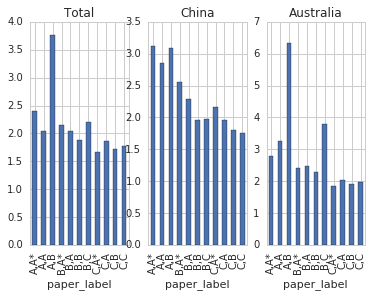

In [37]:
draw_paper_distribution(df_paper_raw, df_author, df_a2p, -1, -1, -1) #第一个 -1 表示不限制年份

### 3.3.2 The distribution for all authors for the top H-index's authors

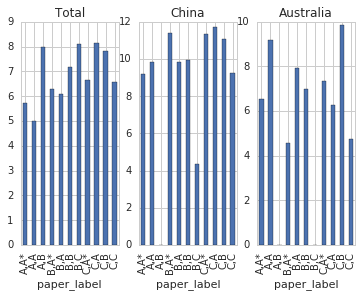

In [38]:
draw_paper_distribution(df_paper_raw, df_author, df_a2p, -1, 11, 60)

### 3.3.3 The distribution for all authors for the high H-index's authors

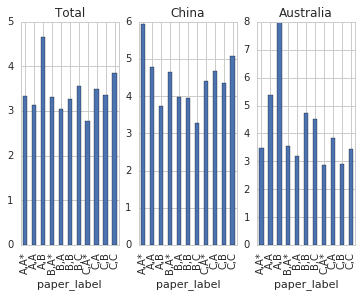

In [39]:
draw_paper_distribution(df_paper_raw, df_author, df_a2p, -1, 4, 10)

### 3.3.4 The distribution for all authors for the higher H-index's authors

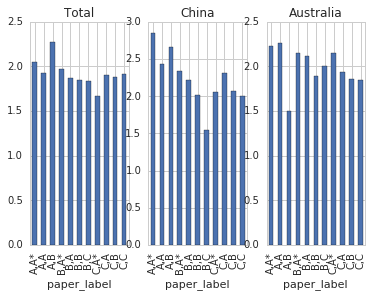

In [40]:
draw_paper_distribution(df_paper_raw, df_author, df_a2p, -1, 2, 3)

### 3.3.5 The distribution for all authors for the lower H-index's authors

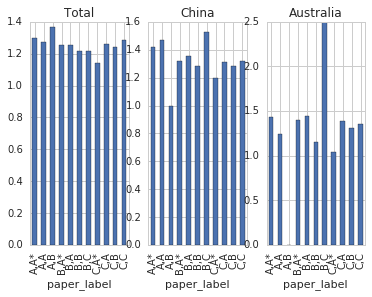

In [41]:
draw_paper_distribution(df_paper_raw, df_author, df_a2p, -1, 1, 1)

### 3.3.6 The distribution for all authors for the low H-index's authors

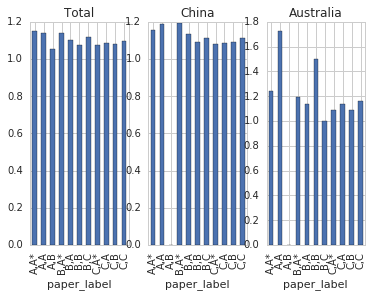

In [42]:
draw_paper_distribution(df_paper_raw, df_author, df_a2p, -1, 0, 0)

## 3.4 Distribution of the number of reference of papers in China and Australia

In [43]:
def draw_ref_distribution(df_relationship, dst_publicationYear, Hindex_lowerbound, Hindex_higherbound, fre = False):

    if dst_publicationYear != -1:
        #目的的发表年份受限，应按发表年份删选
        df_relationship = df_relationship[df_relationship['relationship_dst_publicationYear'] == dst_publicationYear]
    if Hindex_lowerbound != -1:
        df_relationship = df_relationship[df_relationship['relationship_dst_maxHindex'] >= Hindex_lowerbound]

    if Hindex_higherbound != -1:
        df_relationship = df_relationship[df_relationship['relationship_dst_maxHindex'] <= Hindex_higherbound]

    grouped = df_relationship.groupby(['relationship_dst_label', 'relationship_src_label'])
    grouped_China = df_relationship[df_relationship['relationship_dst_country'] == 'China'].groupby(['relationship_dst_label', 'relationship_src_label'])
    grouped_Australia = df_relationship[df_relationship['relationship_dst_country'] == 'Australia'].groupby(['relationship_dst_label', 'relationship_src_label'])


    #各类venue的个数
    #cnt_venue = df_relationship.drop_duplicates(['relationship_src_label', 'relationship_dst_label', 'relationship_src_ccfid']).groupby(['relationship_dst_label', 'relationship_src_label']).size().unstack()
    #cnt_venue_China = df_relationship[df_relationship['relationship_dst_country'] == 'China'].drop_duplicates(['relationship_src_label', 'relationship_dst_label', 'relationship_src_ccfid']).groupby(['relationship_dst_label', 'relationship_src_label']).size().unstack()
    #cnt_venue_Australia = df_relationship[df_relationship['relationship_dst_country'] == 'Australia'].drop_duplicates(['relationship_src_label', 'relationship_dst_label', 'relationship_src_ccfid']).groupby(['relationship_dst_label', 'relationship_src_label']).size().unstack()
    
    #论文个数
    cnt_paper = df_relationship.drop_duplicates(['relationship_dst']).groupby(['relationship_dst_label']).size()
    cnt_paper_China = df_relationship[df_relationship['relationship_dst_country'] == 'China'].drop_duplicates(['relationship_dst']).groupby(['relationship_dst_label']).size()
    cnt_paper_Australia = df_relationship[df_relationship['relationship_dst_country'] == 'Australia'].drop_duplicates(['relationship_dst']).groupby(['relationship_dst_label']).size()
    
    #各类引用情况
    cnt_ref = grouped.size().unstack()
    cnt_ref_China = grouped_China.size().unstack()
    cnt_ref_Australia = grouped_Australia.size().unstack()

    #计算比值
    #prop = cnt_ref / cnt_venue
    #prop_China = cnt_ref_China / cnt_venue_China
    #prop_Australia = cnt_ref_Australia / cnt_venue_Australia
    
    prop = cnt_ref.astype('float') / cnt_paper[:, np.newaxis].repeat(cnt_ref.shape[1], axis=1)
    #prop = prop.reindex(['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C'])[['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C']]
    prop_China = cnt_ref_China.astype('float') / cnt_paper_China[:, np.newaxis].repeat(cnt_ref_China.shape[1], axis=1)
    #prop_China = prop_China.reindex(['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C'])[['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C']]
    prop_Australia = cnt_ref_Australia.astype('float') / cnt_paper_Australia[:, np.newaxis].repeat(cnt_ref_Australia.shape[1], axis=1)
    #prop_Australia = prop_Australia.reindex(['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C'])[['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C']]
    

    #画图, 规格化
    fig, axes = plt.subplots(1,3)
    #fig.figsize= (50, 40)
    #fig.
    if fre == True:
        #画比例图，归到0,1之间
        prop.div(prop.sum(1).astype(float), axis = 0).plot(kind='bar', figsize=(16,12), sharey=True, ax=axes[0], stacked=True, ylim=[0,1], colormap='gist_rainbow', legend=False, grid=True, title = 'Total')
        prop_China.div(prop_China.sum(1).astype(float), axis = 0).plot(kind='bar', figsize=(16,12), sharey=True, ax=axes[1], stacked=True, ylim=[0,1], colormap='gist_rainbow', legend=False, grid=True, title = 'China')
        prop_Australia.div(prop_Australia.sum(1).astype(float), axis = 0).plot(kind='bar', figsize=(16,12), sharey=True, ax=axes[2], stacked=True, ylim=[0,1], colormap='gist_rainbow', legend=False, grid=True, title = 'Australia')
    else:
        #画比例图，不归一
        prop.plot(kind='bar', ax=axes[0], figsize=(16,12), stacked=True, colormap='gist_rainbow', legend=False,  title = 'Total')
        prop_China.plot(kind='bar', ax=axes[1], figsize=(16,12), stacked=True, colormap='gist_rainbow', legend=False, title = 'China')
        prop_Australia.plot(kind='bar', ax=axes[2], figsize=(16,12), stacked=True, colormap='gist_rainbow', legend=False, title = 'Australia')

**In there, we compute the average number of reference for every author. And author_H_Index refers to the max H-index of a paper. **

### 3.4.1 Legend

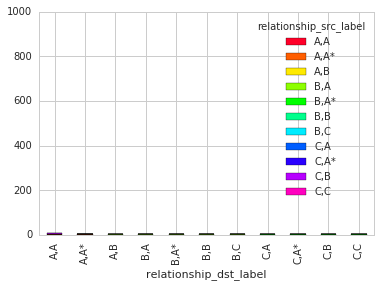

In [44]:
cnt_paper = df_relationship.drop_duplicates(['relationship_dst']).groupby(['relationship_dst_label']).size()
grouped = df_relationship.groupby(['relationship_dst_label', 'relationship_src_label'])
cnt_ref = grouped.size().unstack()
prop = cnt_ref.astype('float') / cnt_paper[:, np.newaxis].repeat(11, axis=1)
#prop = prop.reindex(['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C'])[['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C']]
prop.plot(kind='bar', stacked=True, colormap='gist_rainbow', legend=True, ylim=[0, 1000])

### 3.4.2 All papers without considering H-index

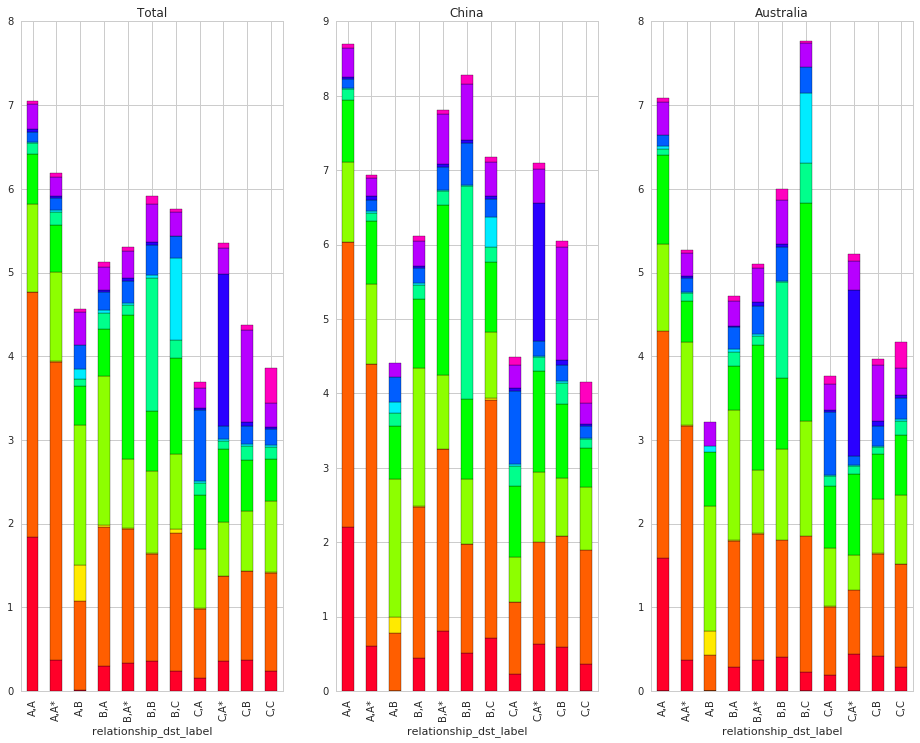

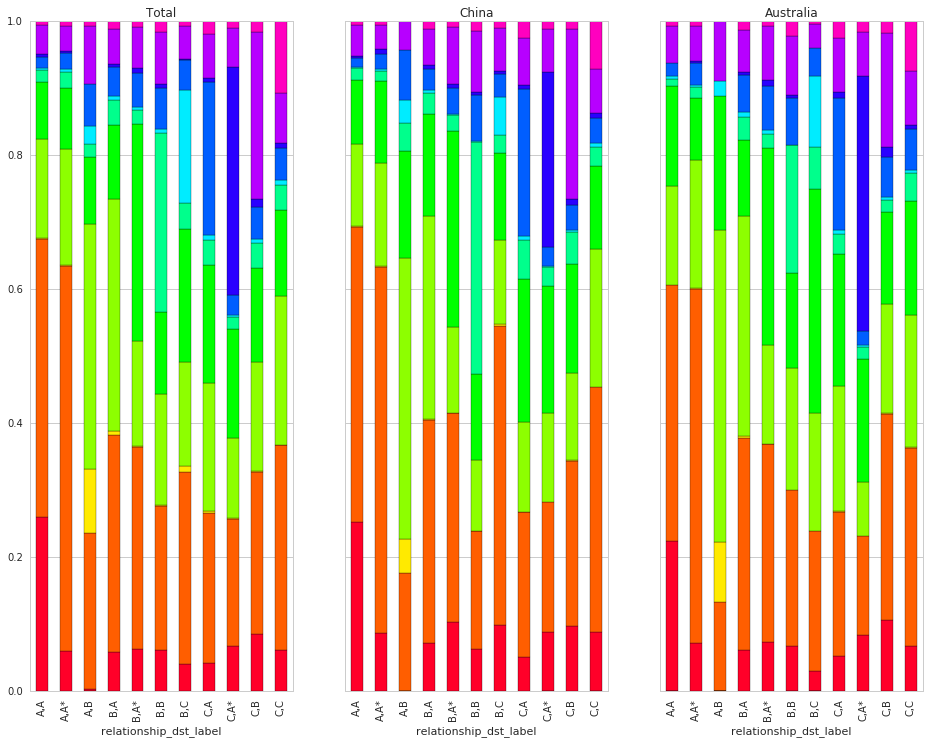

In [45]:
draw_ref_distribution(df_relationship, -1, 0, 60)
draw_ref_distribution(df_relationship, -1, 0, 60, True)

### 3.4.3 Papers published by top H-index authors

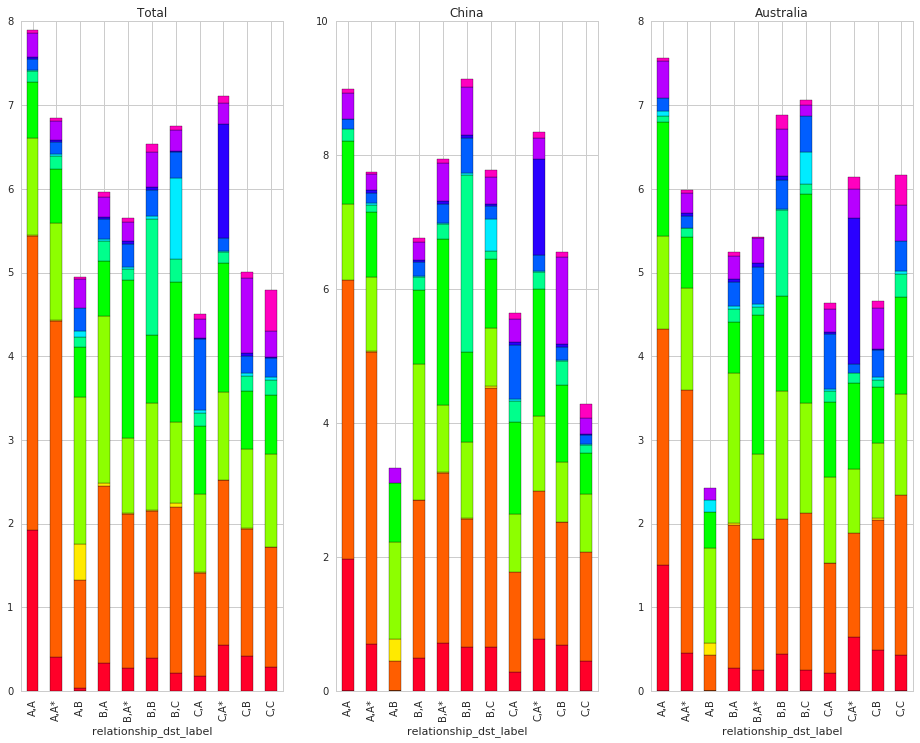

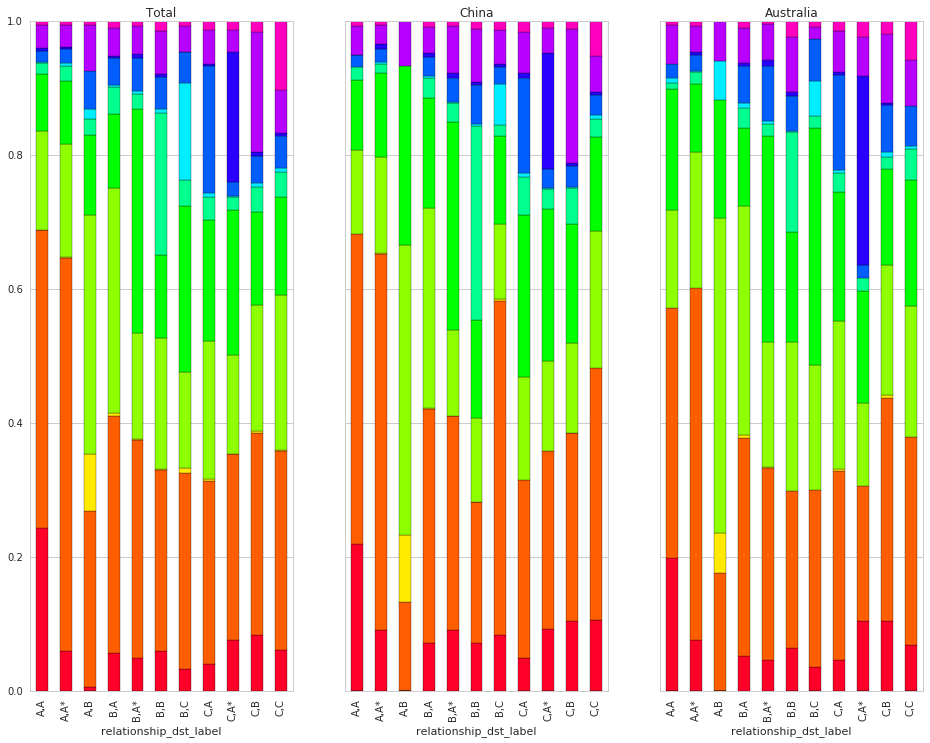

In [46]:
draw_ref_distribution(df_relationship, -1, 11, 60)
draw_ref_distribution(df_relationship, -1, 11, 60, True)

### 3.4.4 Papers published by high H-index authors

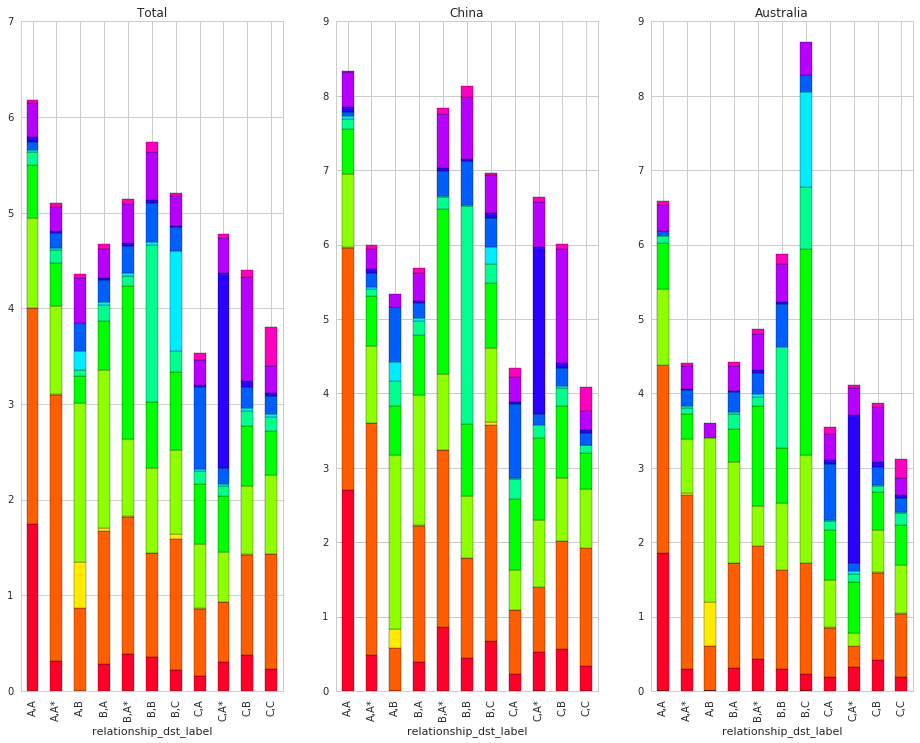

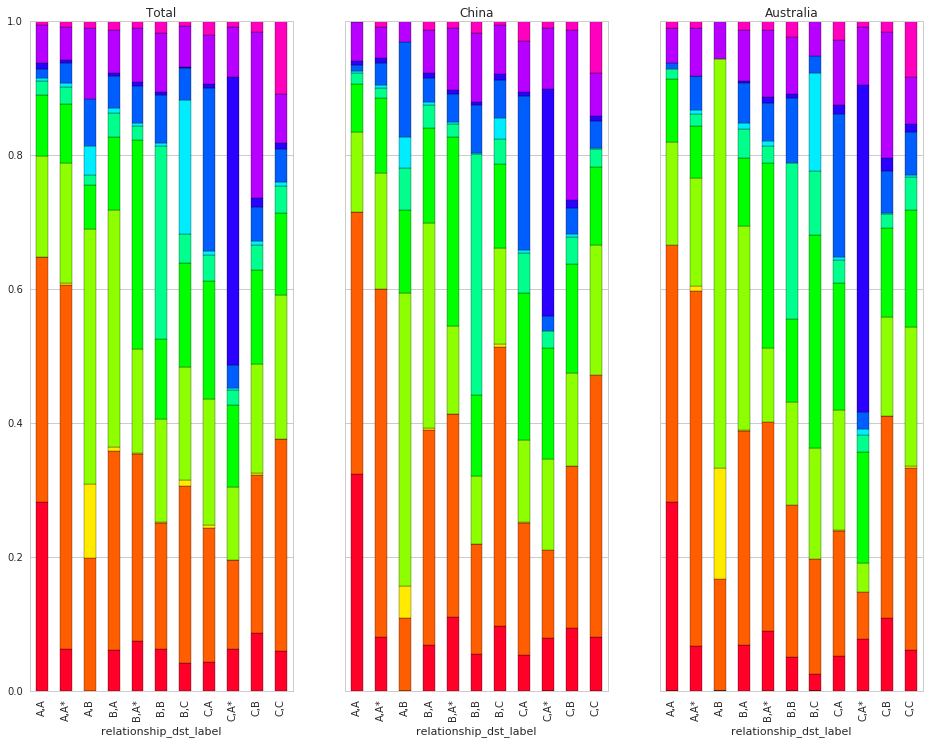

In [47]:
draw_ref_distribution(df_relationship, -1, 4, 10)
draw_ref_distribution(df_relationship, -1, 4, 10, True)

### 3.4.5 Papers published by higher H-index authors

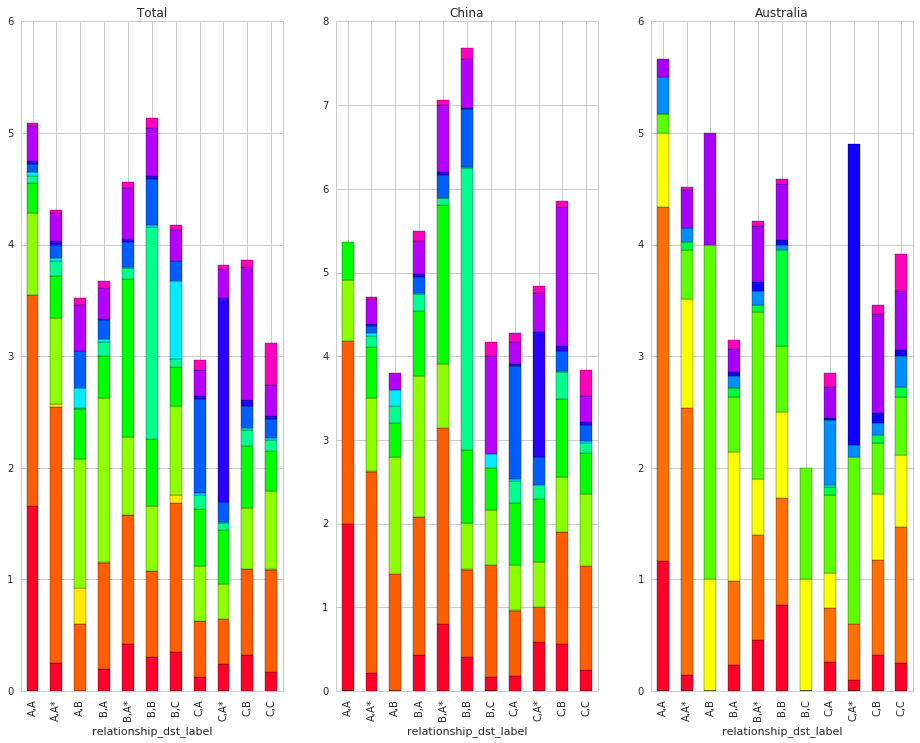

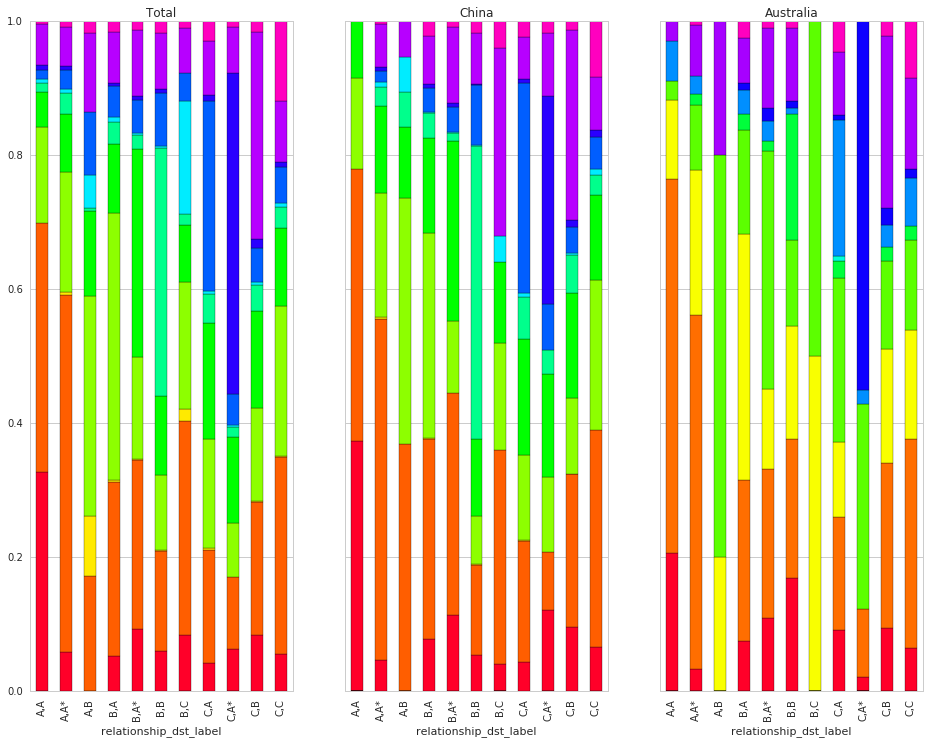

In [48]:
draw_ref_distribution(df_relationship, -1, 2, 3)
draw_ref_distribution(df_relationship, -1, 2, 3, True)

### 3.4.3 Papers published by lower H-index authors

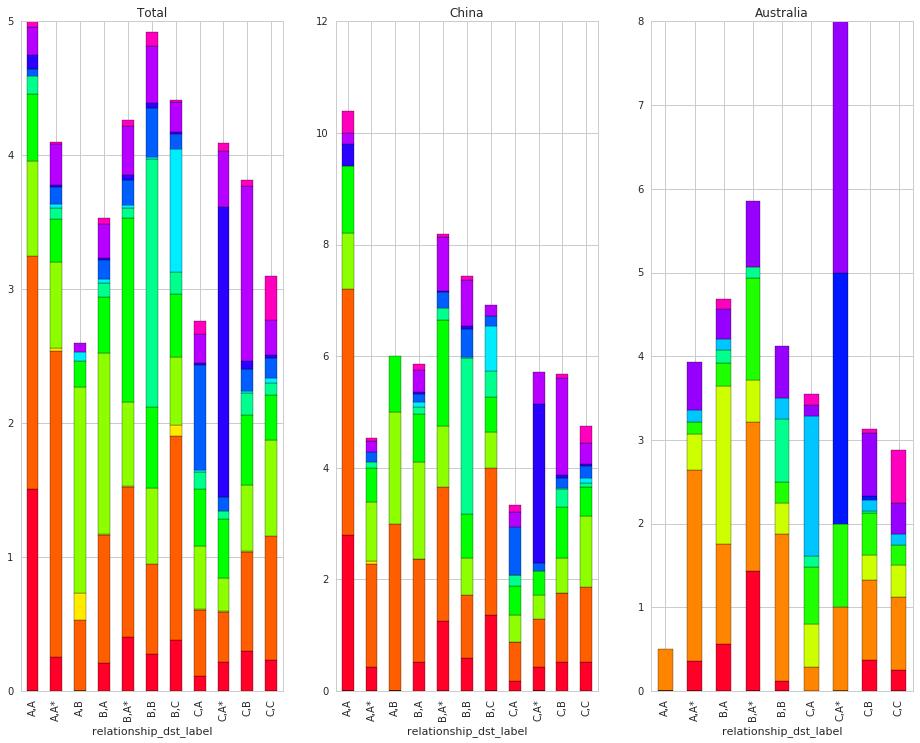

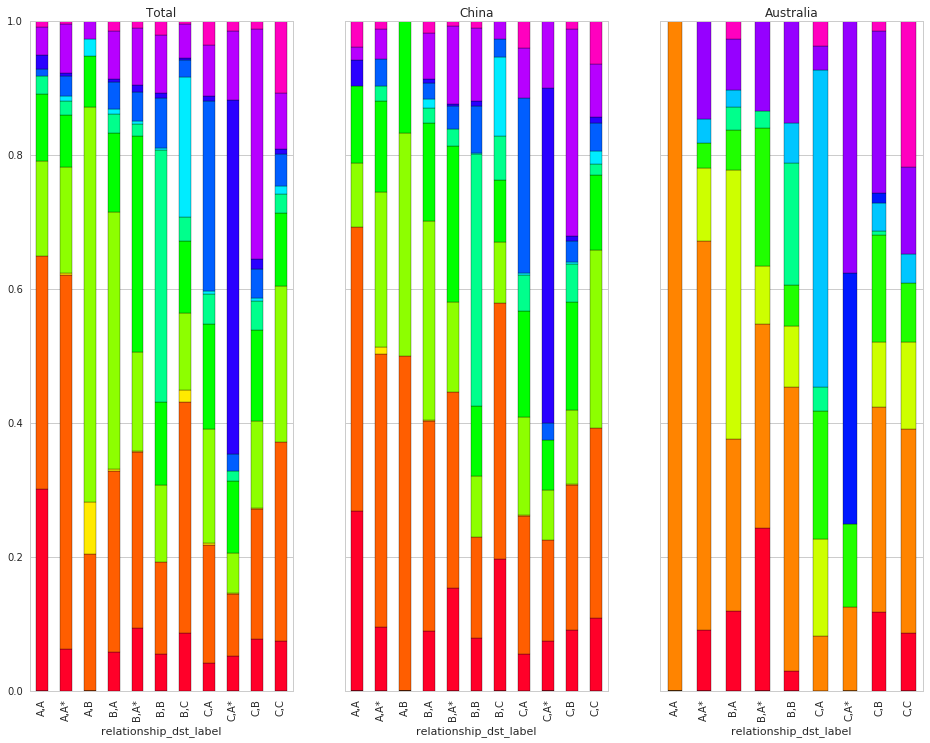

In [49]:
draw_ref_distribution(df_relationship, -1, 1, 1)
draw_ref_distribution(df_relationship, -1, 1, 1, True)

### 3.4.3 Papers published by low H-index authors

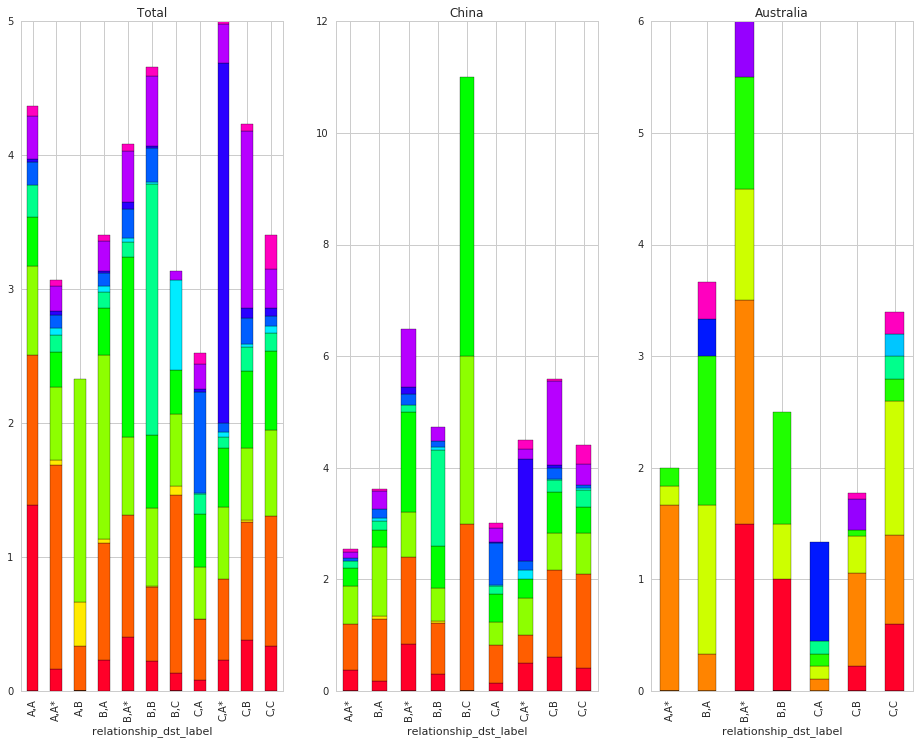

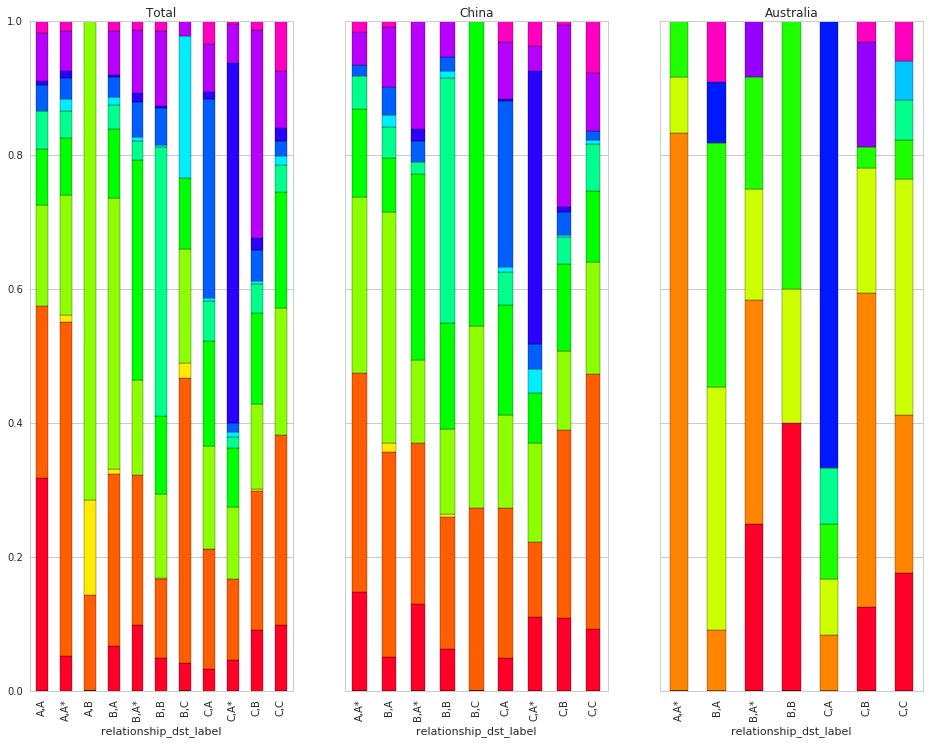

In [50]:
draw_ref_distribution(df_relationship, -1, 0, 0)
draw_ref_distribution(df_relationship, -1, 0, 0, True)

# 4 Observation about top papers cited by top max H-index papers

We want to observe that top papers, which refer to the number of citation is top 100), are cited by top max H-index papers, whose max H-index is greater than or equal to 11.

In [51]:
def topreasearch_situation(df_paper, df_relationship, paper_publicationYear):
    #在指定年份中引用量前100的研究中，每年高水平H因子作者引用的次数,高水平指的是H因子在35以上的
    df_tmp = df_paper
    if paper_publicationYear != -1:
        df_tmp = df_paper[df_paper['paper_publicationYear'] == paper_publicationYear]
    df_100 = df_tmp.sort_index(by='paper_nbCitation', ascending=False)[:100]
    df1 = pd.merge(df_100, df_relationship, left_on = 'paper_id', right_on='relationship_src')
    #找最大H因子在11以上的
    df1 = df1[(df1['relationship_dst_maxHindex']>=11) & (df1['relationship_dst_maxHindex']<=60)]
    group_series = df1.groupby(['relationship_dst_publicationYear']).size()
    df2 = DataFrame(group_series)
    df2['year'] = df2.index
    if paper_publicationYear == -1:
        df2.columns = ['Total', 'year']
    else:
        df2.columns = [str(paper_publicationYear), 'year']
    return df2

In [52]:
def top_allyear(df_paper, df_relationship):
    df_set = topreasearch_situation(df_paper, df_relationship, -1) #总的情况
    for paper_publicationYear in range(2000,2006):
        df_tmp = topreasearch_situation(df_paper, df_relationship, paper_publicationYear)
        df_set = pd.merge(df_set, df_tmp, how='outer')
    return df_set

In [53]:
df_set = top_allyear(df_paper, df_relationship)

df_set.index = df_set.year

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  


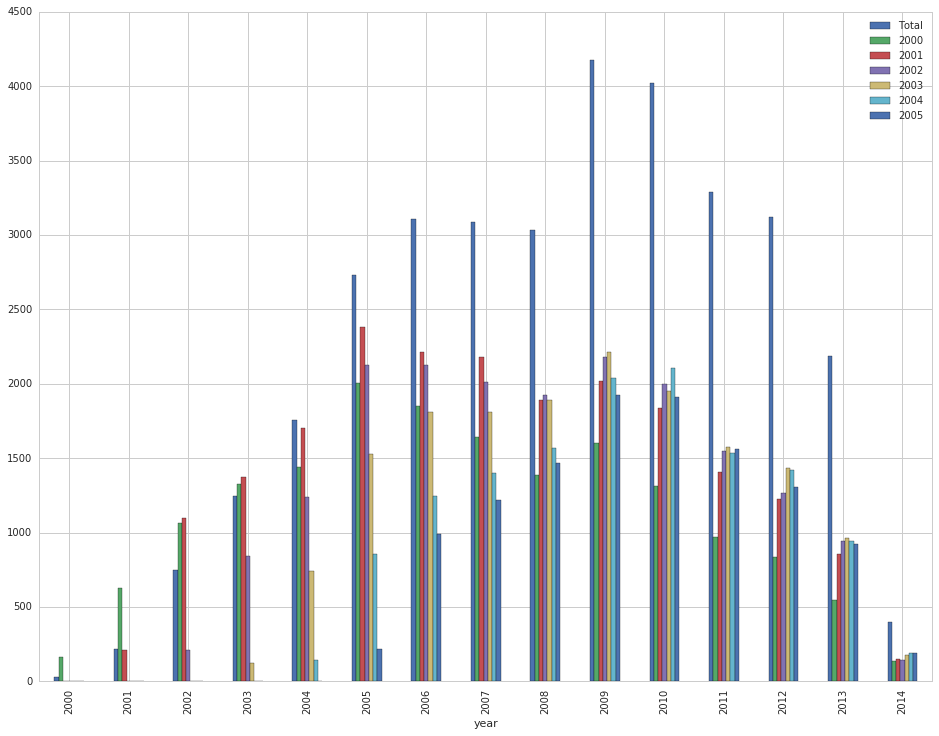

In [54]:
df_set[['Total', '2000','2001','2002','2003','2004', '2005']].plot(kind='bar', figsize=(16,12))

**Why the total bar is often less than every year?**

Because we select top 100 papers which have the highest citaiton. For total situation, their total citation is the highest but not every year is the highest. However, if we consider the year 2003, for example, we select top 100 papers in 2003. Hence, it's possible that the total bar is less than the situation of special year.

# 5 Consider A,B; C,A\*; C,A

## 5.1 Which venues are belong to the three parts?

### 5.1.1 For C,A*

In [55]:
df_ccf = get_ccf(conn)
df_dblp2ccf = get_dblp2ccf(conn)
df_core = get_core(conn)
df_dblp2core = get_dblp2core(conn)

In [56]:
df_ccf_tmp = pd.merge(df_ccf, df_dblp2ccf, left_on='CCF_id', right_on='ccf_CCF_id')
df_core_tmp = pd.merge(df_core, df_dblp2core, left_on='CORE_id', right_on='core_CORE_id')
df_tmp = pd.merge(df_ccf_tmp, df_core_tmp, left_on = 'dblp_dblp_id', right_on='dblp_dblp_id', how='outer')
df_tmp = df_tmp[df_tmp['dblp_dblp_id'] < 999999999]
df_combine = df_tmp[['dblp_dblp_id', 'CCF_id', 'CORE_id', 'CCF_dblpname', 'CORE_dblpname', 'computercategory_computerCategory_id', 'CCF_type', 'CCF_classification', 'CORE_classification']]
df_combine.columns = ['dblp_id', 'CCF_id', 'CORE_id', 'CCF_dblpname', 'CORE_dblpname', 'computerCategory', 'type', 'CCF_classification', 'CORE_classification']
#df_combine = df_combine.drop_duplicates(['dblpname'])

In [57]:
df_combine.count()

dblp_id                2377
CCF_id                  570
CORE_id                2254
CCF_dblpname            570
CORE_dblpname          2254
computerCategory        570
type                    570
CCF_classification      570
CORE_classification    2254
dtype: int64

In [58]:
df_combine[(df_combine['CCF_classification']=='C') & (df_combine['CORE_classification']=='A*')]

,dblp_id,CCF_id,CORE_id,CCF_dblpname,CORE_dblpname,computerCategory,type,CCF_classification,CORE_classification
9186,234,306.0,31.0,WSDM,WSDM,5.0,conference,C,A*
9284,1813,407.0,785.0,ISMAR,ISMAR,7.0,conference,C,A*
9326,110,447.0,3031.0,Decision Support Systems,Decision Support Systems,8.0,journal,C,A*
9436,554,559.0,3070.0,IEEE Trans. Information Technology in Biomedicine,IEEE Trans. Information Technology in Biomedicine,10.0,journal,C,A*
9437,4114,559.0,3070.0,IEEE Trans. Information Technology in Biomedicine,IEEE Trans. Information Technology in Biomedicine,10.0,journal,C,A*


There are 4 venues in **C,A\***. For dblp_id = 554 and 4114, we can know the venue change its name in 2013. Hence, we get two same venue but different venue name. So we think there are 4 venues in this part.

We can compute the probability about papers for different countries' authors.

In [190]:
df_paper.columns

Index([u'paper_id', u'paper_title', u'paper_publicationYear',
       u'paper_nbCitation', u'paper_label', u'venue_venue_id',
       u'author_H_Index', u'CCF_type', u'computercategory_computerCategory_id',
       u'CCF_id', u'author_affiliation_name', u'country'],
      dtype='object')

In [208]:
def get_venue_author(df_paper, id, H_low=-1, H_high=-1, venue='CCF'):
    if H_low != -1:
        df_paper = df_paper[df_paper['author_H_Index'] >= H_low]
    if H_high != -1:
        df_paper = df_paper[df_paper['author_H_Index'] <= H_high]
    
    df_paper['country'] = df_paper['country'].fillna('Other')
    if venue == 'CCF':
        df_venue = df_paper[df_paper['CCF_id']== id]
    if venue == 'CORE':
        df_venue = df_paper[df_paper['CORE_id']== id]
    grouped = df_venue.groupby(['country'])
    return grouped

In [209]:
df_WSDM = get_venue_author(df_paper, 559, 0, 1)
df_WSDM.size()

country
Australia      5
China          9
Other        167
dtype: int64

In [210]:
df_INFOCOM = get_venue_author(df_paper, 103)
df_INFOCOM.size()

country
Australia      1
China         41
Other        338
dtype: int64

# 6 Compute H-index like Google Scholar

## 6.1 CCF and CORE's boxplots respectively

In [61]:
df_paper_raw = get_paper(conn)
df_venue = get_venue(conn)

df_paper_tmp = pd.merge(df_paper_raw, df_venue, left_on = 'venue_venue_id', right_on='venue_id')

We find some venues have small paper. So we need drop some venues and can't consider them.

**We delete venues where the number of papers is less than 100.**

In [62]:
def get_venue_Hindex(df_paper_tmp, df_venue_tmp, prefix="CCF"):
    
    #Define name:
    ID = prefix + "_id"
    CLASSIFICATION = prefix + "_classification"
    INDEX = prefix + '_Hindex'
    PAPER = prefix + '_cntPaper'
    
    df_paper_tmp2 = df_paper_tmp[df_paper_tmp['dblp_dblp_id'] < 999999999]
    df_cur_tmp2 = df_venue_tmp[df_venue_tmp['dblp_dblp_id'] < 999999999]
    df_venue_tmp2 = pd.merge(df_cur_tmp2, df_paper_tmp2, left_on='dblp_dblp_id', right_on='dblp_dblp_id')
    grouped = df_venue_tmp2.groupby(ID)
    
    dic = {}
    for i,j in grouped:
        res = j.sort_values(by='paper_nbCitation', ascending=False)['paper_nbCitation']
        res = DataFrame(res)
        res.columns=['nbCitation']
        res['index'] = range(1, res['nbCitation'].count()+1)
        h_index = res[res['nbCitation'] > res['index']]['index'].count()
        dic[i] = h_index
    df_dic = Series(dic)#, columns=['paper_id','H_index'])
    
    df_grouped = grouped.size()
    df_tmp2 = pd.merge(DataFrame(df_dic), DataFrame(df_grouped), left_index=True, right_index=True)
    df_tmp2.columns = [INDEX, PAPER]
    # Delete the number of papers is less than 100
    df_tmp3 = df_tmp2[df_tmp2[PAPER] >= 100]#.sort_values(by='H_index', ascending=False)

    df_cur_merge = pd.merge(df_venue_tmp, df_tmp3, left_on=ID, right_index=True)
    df_cur_merge
    df_cur_H_Index = df_cur_merge[[ID, CLASSIFICATION, PAPER, INDEX, 'dblp_dblp_id']]
    
    return df_cur_H_Index

In [63]:
df_ccf_H_Index = get_venue_Hindex(df_paper_tmp, df_ccf_tmp, prefix="CCF")
df_core_H_Index = get_venue_Hindex(df_paper_tmp, df_core_tmp, prefix="CORE")

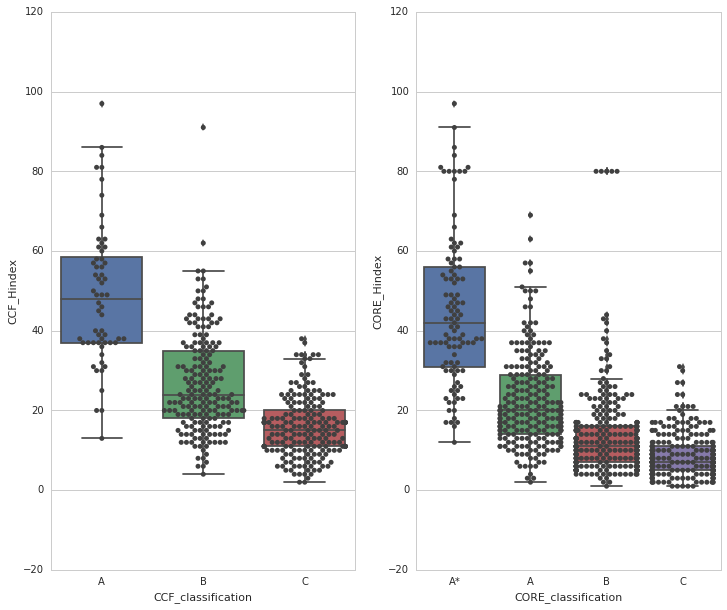

In [64]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12, 10)
sns.boxplot(x='CCF_classification', y='CCF_Hindex', data=df_ccf_H_Index, ax=axes[0])
sns.swarmplot(x="CCF_classification", y="CCF_Hindex", data=df_ccf_H_Index, color=".25", ax=axes[0])

sns.boxplot(x='CORE_classification', y='CORE_Hindex', data=df_core_H_Index, order=['A*', 'A', 'B', 'C'], ax=axes[1])
sns.swarmplot(x="CORE_classification", y="CORE_Hindex", data=df_core_H_Index, color=".25", order=['A*', 'A', 'B', 'C'], ax=axes[1])

## 6.2 Cross parts' distribution

In [65]:
df_core_H_Index = df_core_H_Index.replace(['Australasian', 'L', 'National', 'Not ranked', 'Unranked'], "O")

df_ccf_H_Index_tmp = df_ccf_H_Index.drop_duplicates(['CCF_id'])
df_core_H_Index_tmp = df_core_H_Index.drop_duplicates(['CORE_id'])
df_cross = pd.merge(df_ccf_H_Index_tmp, df_core_H_Index_tmp, how = 'outer')#, left_on='dblp_dblp_id', right_on='dblp_dblp_id')

df_cross[['CCF_classification', 'CORE_classification']] = df_cross[['CCF_classification', 'CORE_classification']].fillna("X")
#df_cross[['CCF_Hindex', 'CORE_Hindex']] = df_cross[['CCF_Hindex', 'CORE_Hindex']].fillna(0)
df_cross['CCF_Hindex'] = df_cross['CCF_Hindex'].fillna(df_cross['CORE_Hindex'])
df_cross['CORE_Hindex'] = df_cross['CORE_Hindex'].fillna(df_cross['CCF_Hindex'])

In [101]:
df_cross['label'] = df_cross['label'] = df_cross['CCF_classification'] + ',' + df_cross['CORE_classification']
df_cur = df_cross[['CCF_id','CORE_id','label', 'CCF_Hindex']]

In [102]:
df_cur.head()

,CCF_id,CORE_id,label,CCF_Hindex
0,1.0,3357.0,"A,A*",31.0
1,2.0,3360.0,"A,A*",37.0
2,3.0,3459.0,"A,A*",37.0
3,4.0,3340.0,"B,A",14.0
4,5.0,3172.0,"B,B",12.0


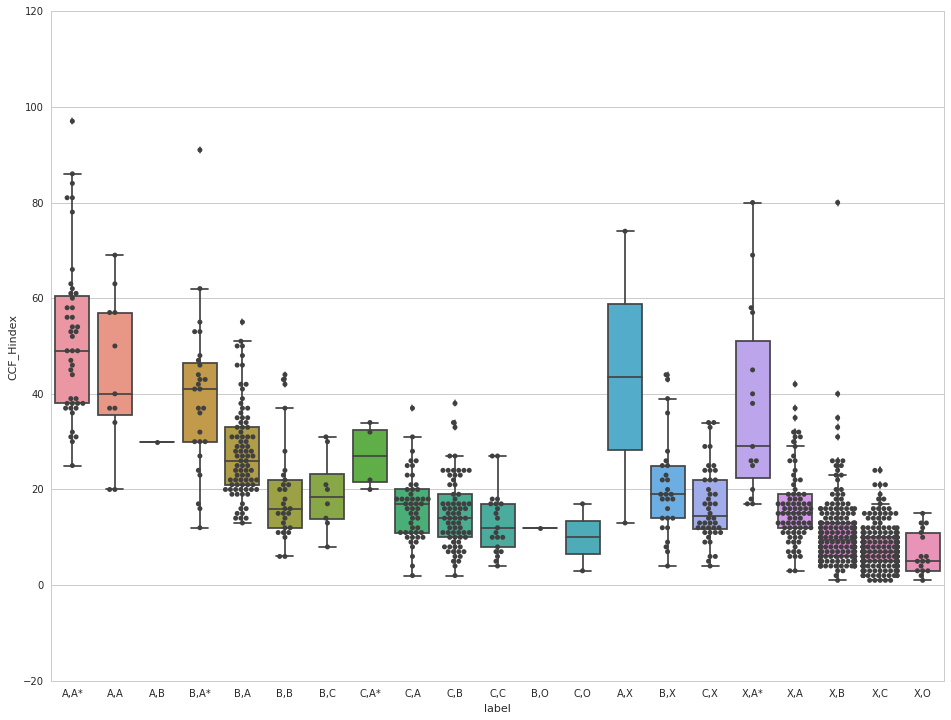

In [103]:
fig = plt.figure()
fig.set_size_inches(16, 12)
sns.boxplot(x='label', y='CCF_Hindex', data=df_cur, \
            order=['A,A*', 'A,A', 'A,B', 'B,A*', 'B,A','B,B','B,C', 'C,A*', 'C,A', 'C,B', 'C,C', \
                   'B,O','C,O', 'A,X', 'B,X', 'C,X', 'X,A*', 'X,A', 'X,B', 'X,C', 'X,O'])
sns.swarmplot(x="label", y="CCF_Hindex", data=df_cur, color=".25", \
            order=['A,A*', 'A,A', 'A,B', 'B,A*', 'B,A','B,B','B,C', 'C,A*', 'C,A', 'C,B', 'C,C', \
                   'B,O','C,O', 'A,X', 'B,X', 'C,X', 'X,A*', 'X,A', 'X,B', 'X,C', 'X,O'])

In [228]:
df_author = filter_author(sql_ip, port, user, passwd, db)

## 6.3 The author distribution in AB; AX; BO; CA\*; CO

In [195]:
df_cur.groupby(['label']).size().sort_values(ascending=False)

label
X,C     239
X,B     194
B,A      85
X,A      81
C,B      71
C,A      51
C,X      44
A,A*     43
B,B      29
B,X      28
B,A*     27
C,C      21
X,O      17
X,A*     15
A,A      11
B,C       8
C,A*      4
C,O       2
A,X       2
B,O       1
A,B       1
dtype: int64

We find that some parts is small and have little venues. Such as **A,B(1); A,X(2); B,O(1); C,A\*(4); C,O(2)**

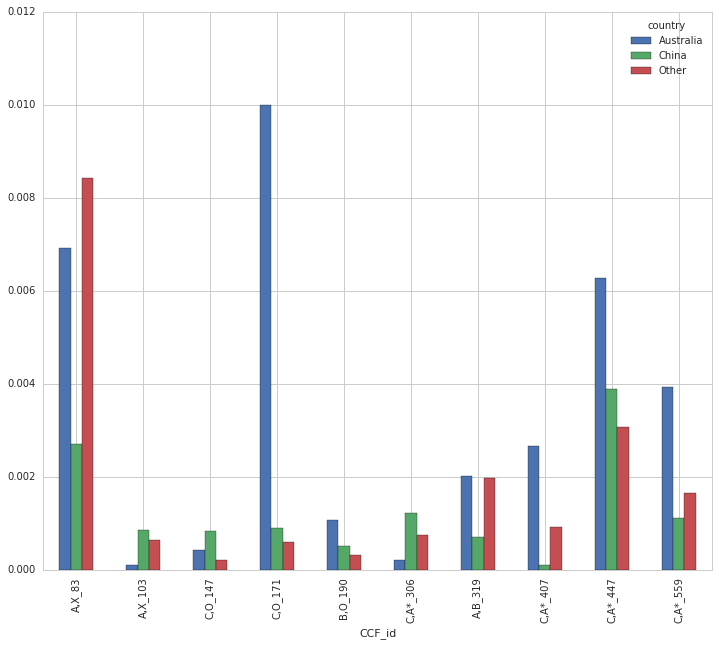

In [285]:
df_tmp = df_cur[(df_cur['label']=='A,B') | (df_cur['label']=='A,X') \
       | (df_cur['label']=='B,O') | (df_cur['label']=='C,A*') | (df_cur['label']=='C,O')]
#df_tmp

df_a2p_tmp = df_a2p[df_a2p['a2p_order']==1].drop_duplicates(['author_author_id'])
df_author_tmp = pd.merge(df_author, df_a2p_tmp, left_on='author_id', right_on='author_author_id')

df_author_tmp['country'] = df_author_tmp['country'].fillna('Other')
df_first = DataFrame(df_author_tmp.groupby(['country']).size())
df_first.columns = ['Total']
df_first

for i in df_tmp['CCF_id']:
    df_venue = get_venue_author(df_paper, i, venue='CCF')
    a = DataFrame(df_venue.size())
    a.columns = df_tmp[df_tmp['CCF_id'] == i]['label'] + '_' + str(int(i))
    df_first = pd.concat([df_first, a], axis=1)

df_first.columns.name = 'CCF_id'

#df_first

df_prop_first = df_first.div(df_first['Total'], axis=0)

#df_prop_first

del df_prop_first['Total']

df_prop_first.T.plot(kind='bar', figsize=(12, 10))

## 6.4 Considering XC; XB; XA; XA\*; BX; CX

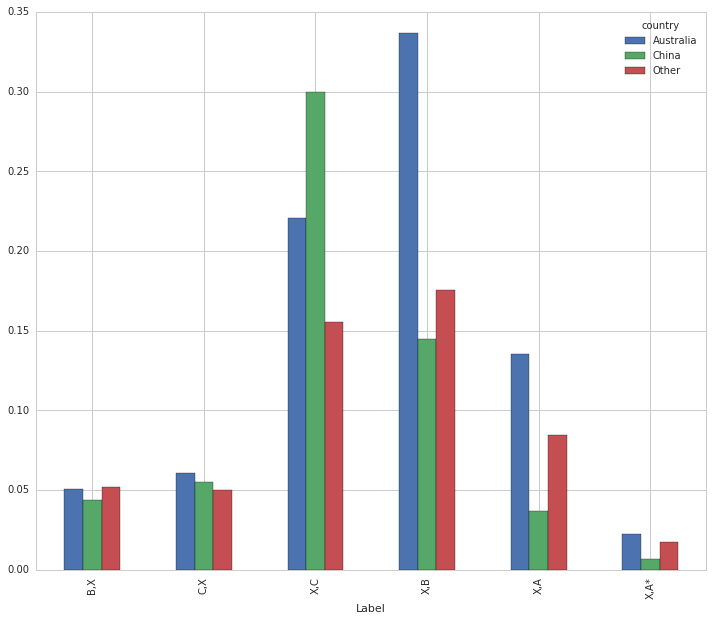

In [286]:
df_tmp = df_cur[(df_cur['label']=='X,C') | (df_cur['label']=='X,B') \
       | (df_cur['label']=='X,A') | (df_cur['label']=='X,A*') | (df_cur['label']=='B,X') | (df_cur['label']=='C,X')]
#df_tmp.head()

df_a2p_tmp = df_a2p[df_a2p['a2p_order']==1].drop_duplicates(['author_author_id'])
df_author_tmp = pd.merge(df_author, df_a2p_tmp, left_on='author_id', right_on='author_author_id')

df_author_tmp['country'] = df_author_tmp['country'].fillna('Other')
df_first = DataFrame(df_author_tmp.groupby(['country']).size())
df_first.columns = ['Total']
#df_first


for label in df_tmp.drop_duplicates(['label'])['label']:
    #print label
    #print '------------------------------------'
    df_paper
    #print i
    df_subset = df_tmp[df_tmp['label'] == label]
    if label[0] == 'X':
        df_res = pd.merge(df_paper, df_subset, left_on='CORE_id', right_on='CORE_id')
        #print df_res
        df_label = df_res.drop_duplicates(['paper_id']).groupby(['country']).size()
    else :
        #Use CCF_id
        df_res = pd.merge(df_paper, df_subset, left_on='CCF_id', right_on='CCF_id')
        #print df_res
        df_label = df_res.drop_duplicates(['paper_id']).groupby(['country']).size()
    #print df_res.columns
    df_label = DataFrame(df_label)
    df_label.columns = [label]
    df_first = pd.concat([df_first, df_label], axis=1)
    #print '*****************************************************************'

#print df_first

df_first.columns.name = 'Label'

#df_first

df_prop_first = df_first.div(df_first['Total'], axis=0)

#df_prop_first

del df_prop_first['Total']

df_prop_first.T.plot(kind='bar', figsize=(12, 10))

## 6.5 Consider all parts

In [308]:
df_paper.head()

,paper_id,paper_title,paper_publicationYear,paper_nbCitation,paper_label,venue_venue_id,author_H_Index,CCF_type,computercategory_computerCategory_id,CCF_id,CORE_id,author_affiliation_name,country
0,1276,Computer algebra applications,2000,0,None,8292,6.0,NaN,NaN,NaN,NaN,NaN,Other
1,2484,The development of computer science,2000,4,None,8293,3.0,NaN,NaN,NaN,NaN,NaN,Other
2,3019,A query interface for IMAGE databases based on...,2000,0,None,8294,11.0,NaN,NaN,NaN,3045.0,"Royal Melbourne Institute of Technology, Melbo...",Australia
3,3020,Quokka: a translator generator using denotatio...,2000,0,None,8294,2.0,NaN,NaN,NaN,3045.0,"Univ. of New South Wales, Kensington, NSW, Aus...",Australia
4,3021,A clause indexing system for PROLOG based on s...,2000,0,None,8294,6.0,NaN,NaN,NaN,3045.0,"Univ. of New South Wales, Sydney, Australia;Un...",Australia


In [311]:
def draw_parts_distribution(df_cur, df_author, df_a2p, df_paper, publicationYear=-1, H_low=-1, H_high=-1):
    #Params:
    #df_cur: venue's label and H-index, including CCF_id, CORE_id, label, CCF_Hindex
    #df_author: author table, which is same as mysql
    #df_a2p: a2p table, which is same as mysql
    #df_paper: which are generated by generate_relationship function.
    
    #Considering condition
    if publicationYear != -1:
        df_paper = df_paper[df_paper['paper_publicationYear'] == publicationYear]
    if H_low != -1:
        df_paper = df_paper[df_paper['author_H_Index'] >= H_low]
#         df_author = df_author[df_author['author_H_Index'] >= H_low]
    if H_high != -1:
        df_paper = df_paper[df_paper['author_H_Index'] <= H_high]
#         df_author = df_author[df_author['author_H_Index'] <= H_high]
    
    df_tmp = df_cur

#     df_a2p_tmp = df_a2p[df_a2p['a2p_order']==1].drop_duplicates(['author_author_id'])
#     df_author_tmp = pd.merge(df_author, df_a2p_tmp, left_on='author_id', right_on='author_author_id')

#     df_author_tmp['country'] = df_author_tmp['country'].fillna('Other')
#     df_first = DataFrame(df_author_tmp.groupby(['country']).size())

    df_paper['country'] = df_paper['country'].fillna('Other')
    df_first = DataFrame(df_paper.groupby(['country']).size())
    df_first.columns = ['Total']

    for label in df_tmp.drop_duplicates(['label'])['label']:
        df_subset = df_tmp[df_tmp['label'] == label]
        #df_subset is the sub set of df_cur, whose label is current loop label
        if label[0] == 'X':
            df_res = pd.merge(df_paper, df_subset, left_on='CORE_id', right_on='CORE_id')
            df_label = df_res.drop_duplicates(['paper_id']).groupby(['country']).size()
        else :
            #Use CCF_id
            df_res = pd.merge(df_paper, df_subset, left_on='CCF_id', right_on='CCF_id')
            df_label = df_res.drop_duplicates(['paper_id']).groupby(['country']).size()
        df_label = DataFrame(df_label)
        df_label.columns = [label]
        df_first = pd.concat([df_first, df_label], axis=1)

    df_first.columns.name = 'Label'

    df_prop_first = df_first.div(df_first['Total'], axis=0)

    del df_prop_first['Total']

    df_prop_first[['A,A*','A,A','A,B','B,A*','B,A','B,B','B,C','C,A*','C,A','C,B','C,C', \
                   'B,O', 'C,O',\
                   'A,X', 'B,X','C,X', \
                   'X,A*','X,A','X,B', 'X,C',\
                   'X,O']].T.plot(kind='bar', figsize=(12, 10))

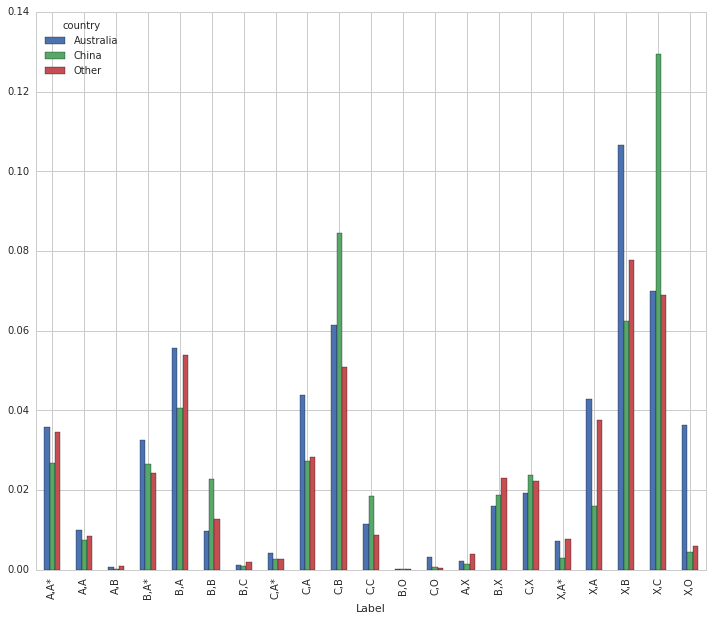

In [312]:
draw_parts_distribution(df_cur, df_author, df_a2p, df_paper)

### 6.5.1 Top H-index author

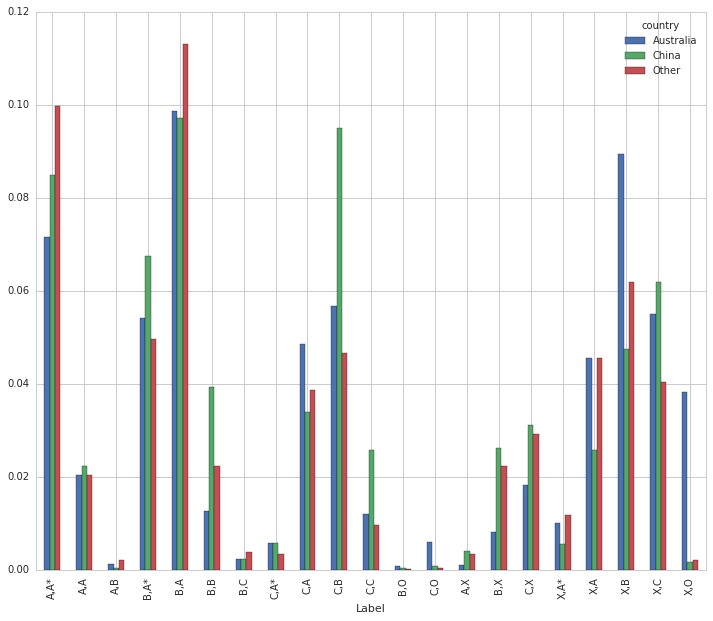

In [315]:
draw_parts_distribution(df_cur, df_author, df_a2p, df_paper, H_low=11, H_high=60)

### 6.5.2 Higher H-index author

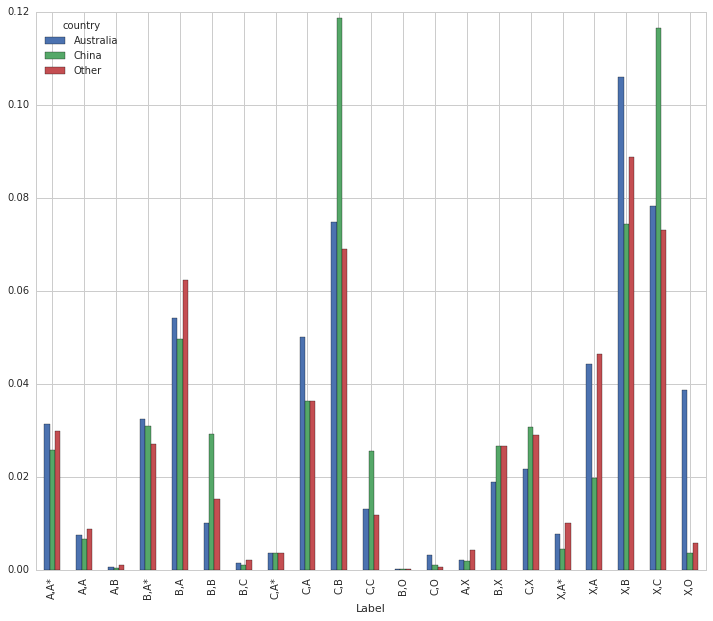

In [316]:
draw_parts_distribution(df_cur, df_author, df_a2p, df_paper, H_low=4, H_high=10)

### 6.5.3 High H-index author

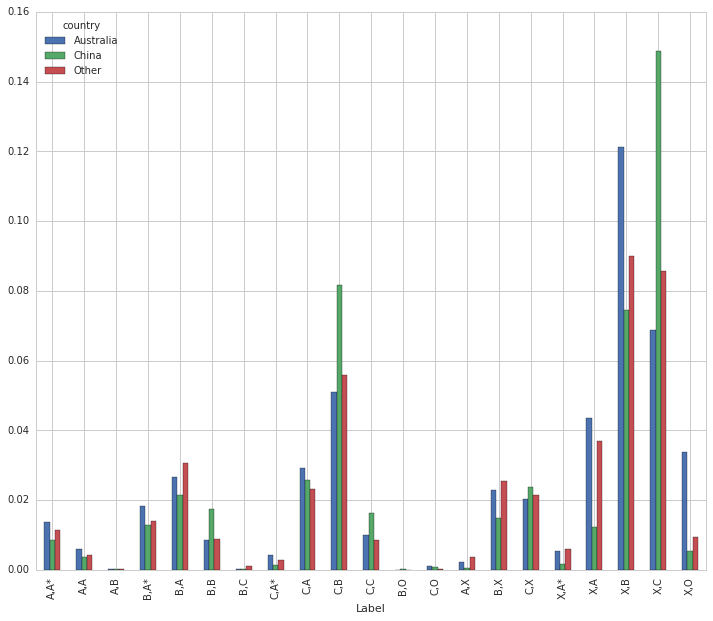

In [317]:
draw_parts_distribution(df_cur, df_author, df_a2p, df_paper, H_low=2, H_high=3)

### 6.5.4 Lower H-index author

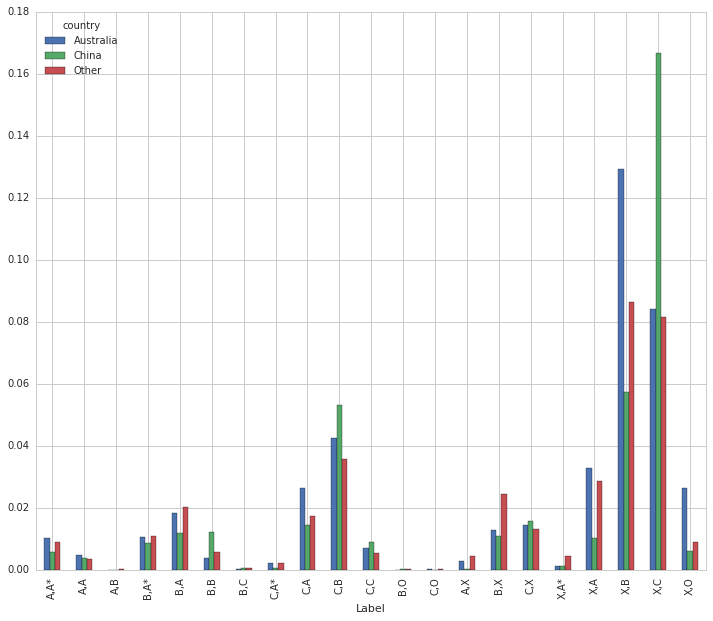

In [318]:
draw_parts_distribution(df_cur, df_author, df_a2p, df_paper, H_low=1, H_high=1)

### 6.5.5 Low H-index author

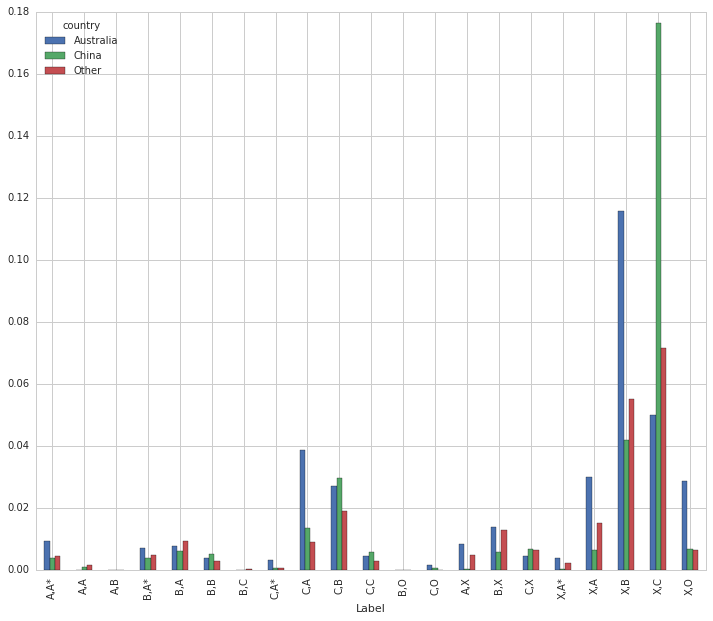

In [319]:
draw_parts_distribution(df_cur, df_author, df_a2p, df_paper, H_low=0, H_high=0)